# Mission
Vous êtes Data Scientist au sein de l’entreprise "**Place de marché**”, qui souhaite lancer une marketplace e-commerce.

Sur la place de marché, des vendeurs proposent des articles à des acheteurs en postant une photo et une description.

Pour l'instant, l'attribution de la catégorie d'un article est effectuée manuellement par les vendeurs, et est donc peu fiable. De plus, le volume des articles est pour l’instant très petit.

Pour rendre l’expérience utilisateur des vendeurs (faciliter la mise en ligne de nouveaux articles) et des acheteurs (faciliter la recherche de produits) la plus fluide possible, et dans l'optique d'un passage à l'échelle, **il devient nécessaire d'automatiser cette tâche**.

**Linda**, Lead Data Scientist, vous demande donc d'étudier la faisabilité d'un **moteur de classification** des articles en différentes catégories, avec un niveau de précision suffisant.

# 1. Preliminaires
## 1.1 Imports

In [1]:
# builtin
import os
from os import listdir
import sys
import time

# data
import numpy as np
import pandas as pd
from sklearn import cluster, metrics
from sklearn import preprocessing

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn import manifold, decomposition
from matplotlib.image import imread

# NLP
import nltk
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import words
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import gensim
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, GlobalAveragePooling1D
from tensorflow.keras.models import Model

# Bert
!pip install transformers # Colab
from transformers import TFAutoModel, AutoTokenizer
import tensorflow_hub as hub

# Download
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('words')
nltk.download('wordnet')

# SIFT
import cv2

# CNN
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 53.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 49.4 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


## 1.2 Paramétrage des graphiques

In [2]:
sns.set_theme(style='whitegrid', palette='pastel')

## 1.3 Récupération du dataset

### Emplacement du fichier

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data = "/content/drive/MyDrive/Yann Pham-Van - Data Scientist - OpenClassrooms/Projet6-Classifiez automatiquement des biens de consommation/data/source/"
os.listdir(data)

['flipkart_com-ecommerce_sample_1050.csv', 'Images']

### Chargement du fichier

In [5]:
fn = data + 'flipkart_com-ecommerce_sample_1050.csv'
df = pd.read_csv(fn, encoding='utf-8')

# 2. Tour d'horizon
## 2.1 Affichage du dataframe

In [6]:
df.head()

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3        2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4        2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   
2                    False  Key Features of Eurospa Cotton Terry Face Towe...   
3                    False  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4                    False  Key Features of Jaipur Print Cotton Floral Kin...   

        product_rating       overall_rating                  brand  \
0  No rating available  No rating available               Elegance   
1  No rating available  No rating available               Sathiyas   
2  No rating available  No rating available                Eurospa   
3  No rating available  No rating available  SANTOSH ROYAL FASHION   
4  No rating available  No rating available           Jaipur Print   

                              product_specifications  
0  {"product_specification"=>[{"key"=>"Brand", "v...  
1  {"product_specification"=>[{"key"=>"Machine Wa...  
2  {"product_specification"=>[{"key"=>"Material",...  
3  {"product_specification"=>[{"key"=>"Brand", "v...  
4  {"product_specification"=>[{"key"=>"Machine Wa...

In [7]:
df.tail()

uniq_id            crawl_timestamp  \
1045  958f54f4c46b53c8a0a9b8167d9140bc  2015-12-01 10:15:43 +0000   
1046  fd6cbcc22efb6b761bd564c28928483c  2015-12-01 10:15:43 +0000   
1047  5912e037d12774bb73a2048f35a00009  2015-12-01 10:15:43 +0000   
1048  c3edc504d1b4f0ba6224fa53a43a7ad6  2015-12-01 10:15:43 +0000   
1049  f2f027ad6a6df617c9f125173da71e44  2015-12-01 10:15:43 +0000   

                                            product_url  \
1045  http://www.flipkart.com/oren-empower-extra-lar...   
1046  http://www.flipkart.com/wallmantra-large-vinyl...   
1047  http://www.flipkart.com/uberlyfe-extra-large-p...   
1048  http://www.flipkart.com/wallmantra-medium-viny...   
1049  http://www.flipkart.com/uberlyfe-large-vinyl-s...   

                                           product_name  \
1045     Oren Empower Extra Large Self Adhesive Sticker   
1046             Wallmantra Large Vinyl Sticker Sticker   
1047  Uberlyfe Extra Large Pigmented Polyvinyl Films...   
1048            Wallmantra Medium Vinyl Sticker Sticker   
1049                       Uberlyfe Large Vinyl Sticker   

                                  product_category_tree               pid  \
1045  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIE88ZGTX65GH4V   
1046  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIEC889ZD5GDCVQ   
1047  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIE5UVGW2JWVWCT   
1048  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIEC889ZGFD3RCE   
1049  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIE2ZEPACRQJKH7   

      retail_price  discounted_price                                 image  \
1045        1399.0             999.0  958f54f4c46b53c8a0a9b8167d9140bc.jpg   
1046        4930.0            1896.0  fd6cbcc22efb6b761bd564c28928483c.jpg   
1047        4500.0            1449.0  5912e037d12774bb73a2048f35a00009.jpg   
1048        3465.0            1333.0  c3edc504d1b4f0ba6224fa53a43a7ad6.jpg   
1049        1190.0             595.0  f2f027ad6a6df617c9f125173da71e44.jpg   

      is_FK_Advantage_product  \
1045                    False   
1046                    False   
1047                    False   
1048                    False   
1049                    False   

                                            description       product_rating  \
1045  Oren Empower Extra Large Self Adhesive Sticker...  No rating available   
1046  Wallmantra Large Vinyl Sticker Sticker (Pack o...  No rating available   
1047  Buy Uberlyfe Extra Large Pigmented Polyvinyl F...  No rating available   
1048  Buy Wallmantra Medium Vinyl Sticker Sticker fo...  No rating available   
1049  Buy Uberlyfe Large Vinyl Sticker for Rs.595 on...                    4   

           overall_rating         brand  \
1045  No rating available  Oren Empower   
1046  No rating available    Wallmantra   
1047  No rating available      Uberlyfe   
1048  No rating available    Wallmantra   
1049                    4      Uberlyfe   

                                 product_specifications  
1045  {"product_specification"=>[{"key"=>"Number of ...  
1046  {"product_specification"=>[{"key"=>"Number of ...  
1047  {"product_specification"=>[{"key"=>"Number of ...  
1048  {"product_specification"=>[{"key"=>"Number of ...  
1049  {"product_specification"=>[{"key"=>"Sales Pack...

In [8]:
df.sample(20)

uniq_id            crawl_timestamp  \
506   8ccc970bf4c55e9b2710d5319161c357  2016-01-07 05:50:25 +0000   
195   2e3586dc60df258c5478446d65a317d2  2015-12-01 12:40:44 +0000   
79    320833ab08c9a94ef83520612899a85f  2016-05-22 16:29:40 +0000   
73    141d2b743c477043041faddf9233c8ad  2016-04-21 20:34:29 +0000   
100   9613f2f1e65fb1fc7e181e7f83c217da  2016-01-04 00:20:04 +0000   
998   78fcb634d9838127464d827234ab05ad  2016-06-26 14:21:24 +0000   
790   75549ef6adc47e9b6dc2b69f530d9097  2015-12-12 11:46:53 +0000   
620   8a184fe2c82ba6a17fbe07f94d0dd875  2016-03-16 23:37:14 +0000   
792   a67d4b8df18ac476cd1b0bbd80e589a4  2015-12-12 11:46:53 +0000   
694   0ae859a69c7608d8197c3ba8c37bc6ec  2015-12-31 09:19:31 +0000   
656   260c74b5a09272dec1a8207db3541a0d  2015-12-31 09:19:31 +0000   
523   8d1abb3504a19ab41e7d8b8b1d5dd839  2016-01-07 05:50:25 +0000   
917   27175ea71cc5f2879882c77b9931cf8b  2016-01-01 13:15:34 +0000   
836   9a9402ad55d079c86c302521816b7b0e  2015-12-29 05:07:38 +0000   
607   1fb0fc88acf0dc6ab9528c26252447e6  2016-03-12 14:25:06 +0000   
754   08e8af585235d7403ca2b7b56a51a6d4  2015-12-12 11:46:53 +0000   
1013  b48218a94e220c20373ed50dc4254093  2016-03-02 19:09:22 +0000   
414   2d4f1232af970bd19881ceacad6ccfe3  2015-12-01 06:13:00 +0000   
179   aab46b84f70cc6774afaafe1d6035de3  2015-12-01 12:40:44 +0000   
121   7dd5e83e2108a97659577e50879f9d9f  2016-03-25 17:27:56 +0000   

                                            product_url  \
506   http://www.flipkart.com/rega-gateway-md7822-md...   
195   http://www.flipkart.com/s-c-handicrafts-sandal...   
79    http://www.flipkart.com/florence9-baby-cap-red...   
73    http://www.flipkart.com/vitamins-solid-baby-gi...   
100   http://www.flipkart.com/goldencollections-gc43...   
998   http://www.flipkart.com/happiness-printed-bone...   
790   http://www.flipkart.com/luba-hf45-stylo-analog...   
620   http://www.flipkart.com/chota-packet-baby-boy-...   
792   http://www.flipkart.com/wild-ferns-lanolin-eye...   
694   http://www.flipkart.com/tallenge-christmas-col...   
656   http://www.flipkart.com/bornbabykids-cotton-ba...   
523   http://www.flipkart.com/maxima-09321cmgy-gold-...   
917   http://www.flipkart.com/megaway-196-85-inch-wh...   
836   http://www.flipkart.com/rrp-alpha-x002-usb-led...   
607   http://www.flipkart.com/aapno-rajasthan-lovely...   
754   http://www.flipkart.com/onlinemaniya-abstract-...   
1013  http://www.flipkart.com/lawman-pg3-striker-win...   
414   http://www.flipkart.com/playboy-london-new-yor...   
179   http://www.flipkart.com/rockmantra-beautiful-g...   
121   http://www.flipkart.com/toffyhouse-baby-boy-s-...   

                                           product_name  \
506   Rega IT Gateway MD7822 MD-7822 MD7822U 6 Cell ...   
195   S C Handicrafts Sandalwood Carved Chinese Quee...   
79                    florence9 baby cap red checks Cap   
73              Vitamins Solid Baby Girl's Basic Shorts   
100   Goldencollections GC4353 Makeup and Jewellery ...   
998                 Happiness Is Printed Bone China Mug   
790             LUBA HF45 Stylo Analog Watch  - For Men   
620       chota packet Baby Boy's, Baby Girl's Bodysuit   
792   Wild Ferns Lanolin Eye Creme with Collagen, Vi...   
694   Tallenge Christmas Collection - Echoes Of Wint...   
656                      BornBabyKids Cotton Bath Towel   
523       Maxima 09321CMGY Gold Analog Watch  - For Men   
917               Megaway 196.85 inch White Rice Lights   
836                        RRP Alpha X002 USB Led Light   
607   Aapno Rajasthan Lovely Jewellery Vanity Jewellery   
754   Onlinemaniya Abstract Single Quilts & Comforte...   
1013  LAWMAN PG3 Striker,, Winger , Contender Deodor...   
414               Playboy London And New York Combo Set   
179   Rockmantra Beautiful Girl With Big Feather Hat...   
121                     Toffyhouse Baby Boy's Sleepsuit   

                                  product_category_tree               pid  \
506   ["Computers >> Lap

## 2.2 Structure

In [9]:
df.shape

(1050, 15)

In [10]:
df.dtypes

uniq_id                     object
crawl_timestamp             object
product_url                 object
product_name                object
product_category_tree       object
pid                         object
retail_price               float64
discounted_price           float64
image                       object
is_FK_Advantage_product       bool
description                 object
product_rating              object
overall_rating              object
brand                       object
product_specifications      object
dtype: object

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [12]:
df.dtypes.value_counts()

object     12
float64     2
bool        1
dtype: int64

In [13]:
tmp = df.nunique()
tmp

uniq_id                    1050
crawl_timestamp             149
product_url                1050
product_name               1050
product_category_tree       642
pid                        1050
retail_price                354
discounted_price            424
image                      1050
is_FK_Advantage_product       2
description                1050
product_rating               27
overall_rating               27
brand                       490
product_specifications      984
dtype: int64

In [14]:
tmp[tmp < 10]

is_FK_Advantage_product    2
dtype: int64

In [15]:
tmp[tmp > 1000]

uniq_id         1050
product_url     1050
product_name    1050
pid             1050
image           1050
description     1050
dtype: int64

## 2.3 Manquants et valeurs dupliquées

In [16]:
df.isna().sum()

uniq_id                      0
crawl_timestamp              0
product_url                  0
product_name                 0
product_category_tree        0
pid                          0
retail_price                 1
discounted_price             1
image                        0
is_FK_Advantage_product      0
description                  0
product_rating               0
overall_rating               0
brand                      338
product_specifications       1
dtype: int64

In [17]:
df.isna().mean().sort_values(ascending=True)

uniq_id                    0.000000
crawl_timestamp            0.000000
product_url                0.000000
product_name               0.000000
product_category_tree      0.000000
pid                        0.000000
image                      0.000000
is_FK_Advantage_product    0.000000
description                0.000000
product_rating             0.000000
overall_rating             0.000000
retail_price               0.000952
discounted_price           0.000952
product_specifications     0.000952
brand                      0.321905
dtype: float64

<Axes: >

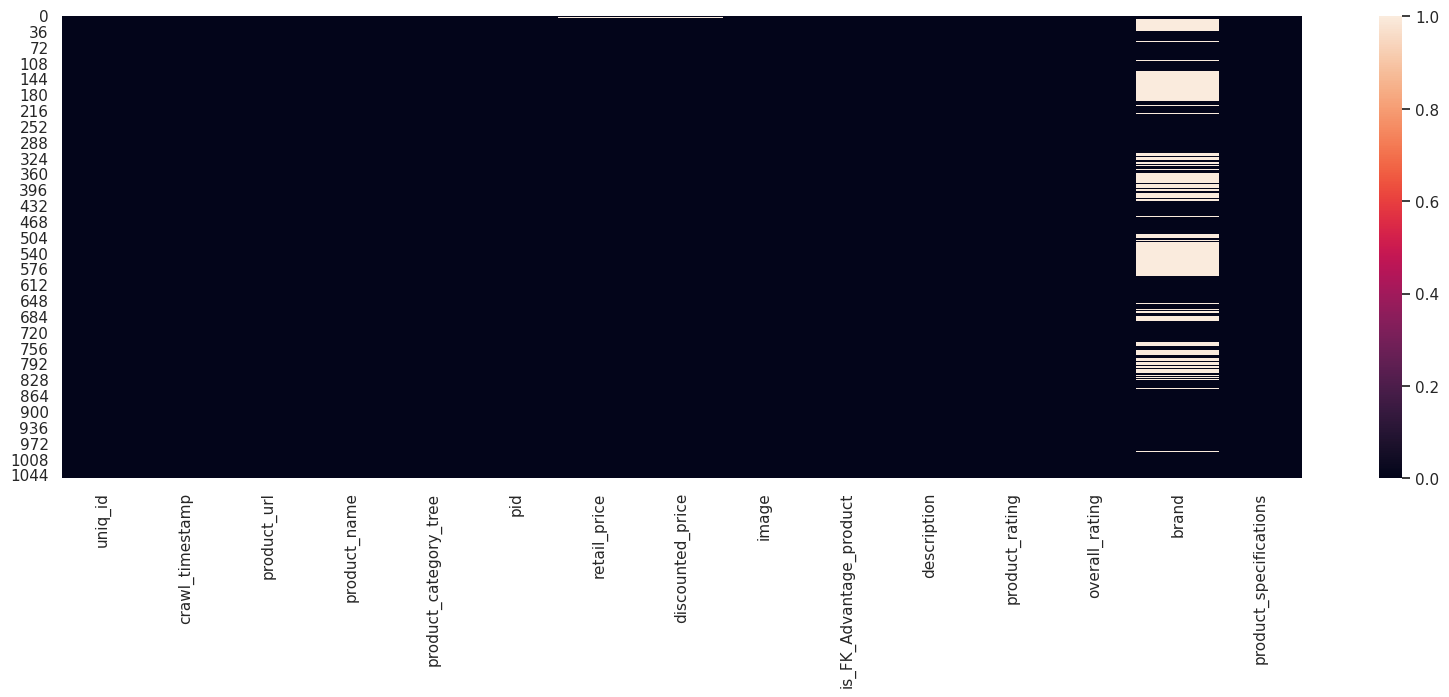

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(20, 6))
sns.heatmap(df.isna())

In [19]:
print('Nombre de valeurs dupliquées par variable :\n')
for col in df.columns:
    n = df.duplicated(subset=col).sum()
    print(f'{col :-<25}{n}')

Nombre de valeurs dupliquées par variable :

uniq_id------------------0
crawl_timestamp----------901
product_url--------------0
product_name-------------0
product_category_tree----408
pid----------------------0
retail_price-------------695
discounted_price---------625
image--------------------0
is_FK_Advantage_product--1048
description--------------0
product_rating-----------1023
overall_rating-----------1023
brand--------------------559
product_specifications---65


## 2.4 Inspection des données

In [20]:
df.describe(include=np.number)

retail_price  discounted_price
count    1049.000000       1049.000000
mean     2186.197331       1584.527169
std      7639.229411       7475.099680
min        35.000000         35.000000
25%       555.000000        340.000000
50%       999.000000        600.000000
75%      1999.000000       1199.000000
max    201000.000000     201000.000000

In [21]:
df.describe(include=object)

uniq_id            crawl_timestamp  \
count                               1050                       1050   
unique                              1050                        149   
top     55b85ea15a1536d46b7190ad6fff8ce7  2015-12-01 12:40:44 +0000   
freq                                   1                        150   

                                              product_url  \
count                                                1050   
unique                                               1050   
top     http://www.flipkart.com/elegance-polyester-mul...   
freq                                                    1   

                                             product_name  \
count                                                1050   
unique                                               1050   
top     Elegance Polyester Multicolor Abstract Eyelet ...   
freq                                                    1   

                                    product_category_tree               pid  \
count                                                1050              1050   
unique                                                642              1050   
top     ["Home Furnishing >> Bed Linen >> Blankets, Qu...  CRNEG7BKMFFYHQ8Z   
freq                                                   56                 1   

                                       image  \
count                                   1050   
unique                                  1050   
top     55b85ea15a1536d46b7190ad6fff8ce7.jpg   
freq                                       1   

                                              description  \
count                                                1050   
unique                                               1050   
top     Key Features of Elegance Polyester Multicolor ...   
freq                                                    1   

             product_rating       overall_rating         brand  \
count                  1050                 1050           712   
unique                   27                   27           490   
top     No rating available  No rating available  PRINT SHAPES   
freq                    889                  889            11   

                                   product_specifications  
count                                                1049  
unique                                                984  
top     {"product_specification"=>[{"key"=>"Type", "va...  
freq                                                   22

# 3. Nettoyage du dataframe

## 3.1 Sélection des colonnes

In [22]:
tmp = df.dtypes
tmp

uniq_id                     object
crawl_timestamp             object
product_url                 object
product_name                object
product_category_tree       object
pid                         object
retail_price               float64
discounted_price           float64
image                       object
is_FK_Advantage_product       bool
description                 object
product_rating              object
overall_rating              object
brand                       object
product_specifications      object
dtype: object

In [23]:
cols = ['brand', 'product_name', 'description', 'product_category_tree', 'image']
df = df[cols]
df.sample(5)

brand                                       product_name  \
875  Nikunj                     Nikunj Abstract Cushions Cover   
416     NaN                           Playboy Berlin Combo Set   
807     NaN  Mxofere Combo Sandal Turmeric Almond Honey Jas...   
672     NaN                      Indha Craft Cloth Photo Frame   
54      JRB  JRB 1033 Smallest Mobile Powered By OTG Enable...   

                                           description  \
875  Nikunj Abstract Cushions Cover (Pack of 5, 40 ...   
416  Flipkart.com: Buy Playboy Berlin Combo Set onl...   
807  Mxofere Combo Sandal Turmeric Almond Honey Jas...   
672  Indha Craft Cloth Photo Frame (Photo Size - 12...   
54   Key Features of JRB 1033 Smallest Mobile Power...   

                                 product_category_tree  \
875                      ["Home Furnishing >> Living"]   
416  ["Beauty and Personal Care >> Fragrances >> De...   
807  ["Beauty and Personal Care >> Combos and Kits ...   
672  ["Baby Care >> Baby & Kids Gifts >> Photo Fram...   
54   ["Computers >> Laptop Accessories >> USB Gadge...   

                                    image  
875  e56ffc10078972b5f4e7302383db8d72.jpg  
416  723e472f98180745980efe32411d30c6.jpg  
807  d0af95243e993331c4357fdf90dc4692.jpg  
672  6eabdbbbffdfae86c3c5177ba0f96ea7.jpg  
54   7e6ae1b372e8e0b509b83ba3658b8107.jpg

## 3.2 Extraction des catégories
Les catégories de produits forment une arborescence.

Les niveaux de catégories sont séparées par les caractères **>>**

Dans le cadre de l'étude de faisabilité de clustering, je vais me concentrer sur la catégorie principale.

In [24]:
df['main_category'] = df['product_category_tree'].apply(lambda x : x.split('["')[1].split(' >> ')[0])
df = df.drop(columns=['product_category_tree'])
df.head(1)

brand                                       product_name  \
0  Elegance  Elegance Polyester Multicolor Abstract Eyelet ...   

                                         description  \
0  Key Features of Elegance Polyester Multicolor ...   

                                  image    main_category  
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg  Home Furnishing

# 4. Analyse exploratoire
## 4.1 Target

In [25]:
df.describe()

brand                                       product_name  \
count            712                                               1050   
unique           490                                               1050   
top     PRINT SHAPES  Elegance Polyester Multicolor Abstract Eyelet ...   
freq              11                                                  1   

                                              description  \
count                                                1050   
unique                                               1050   
top     Key Features of Elegance Polyester Multicolor ...   
freq                                                    1   

                                       image    main_category  
count                                   1050             1050  
unique                                  1050                7  
top     55b85ea15a1536d46b7190ad6fff8ce7.jpg  Home Furnishing  
freq                                       1              150

In [26]:
df.main_category.value_counts()

Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: main_category, dtype: int64

In [27]:
df.main_category.value_counts(normalize=True)

Home Furnishing               0.142857
Baby Care                     0.142857
Watches                       0.142857
Home Decor & Festive Needs    0.142857
Kitchen & Dining              0.142857
Beauty and Personal Care      0.142857
Computers                     0.142857
Name: main_category, dtype: float64

<Axes: ylabel='main_category'>

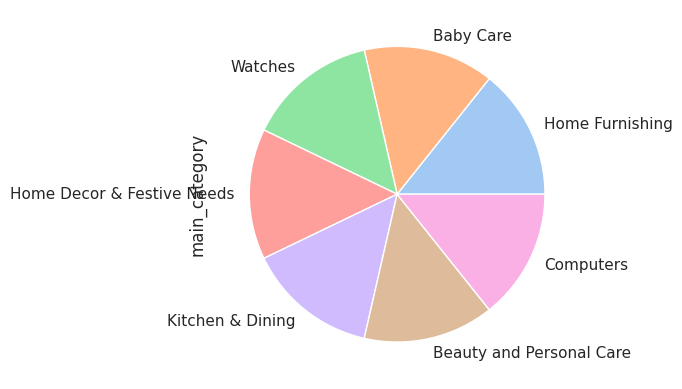

In [28]:
df.main_category.value_counts().plot(kind='pie')

**Les 7 catégories sont parfaitement équilibrées.**

## 4.2 Descriptions

In [29]:
df.description.apply(lambda i : len(i))

0       1420
1        444
2       1258
3        858
4       1197
        ... 
1045    2432
1046    1660
1047     262
1048     210
1049     187
Name: description, Length: 1050, dtype: int64

<Axes: >

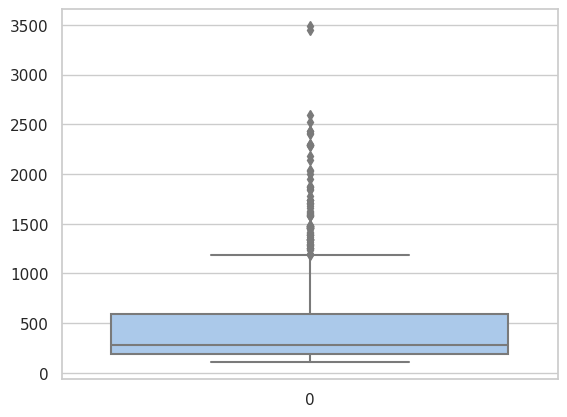

In [30]:
tmp = df.description.str.len()
sns.boxplot(tmp)

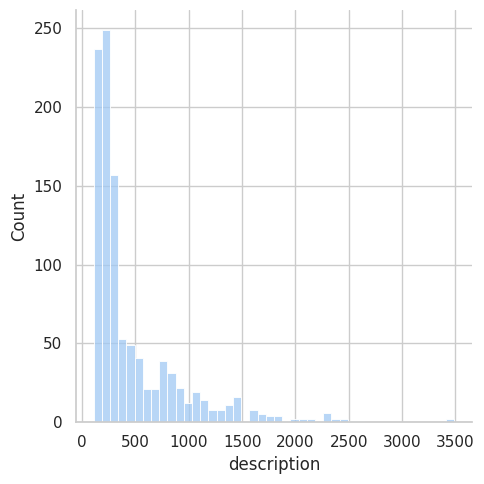

In [31]:
sns.displot(tmp)

## 4.3 Noms des produits

In [32]:
df.product_name.apply(lambda i : len(i))

0       58
1       26
2       35
3       63
4       53
        ..
1045    46
1046    38
1047    65
1048    39
1049    28
Name: product_name, Length: 1050, dtype: int64

<Axes: >

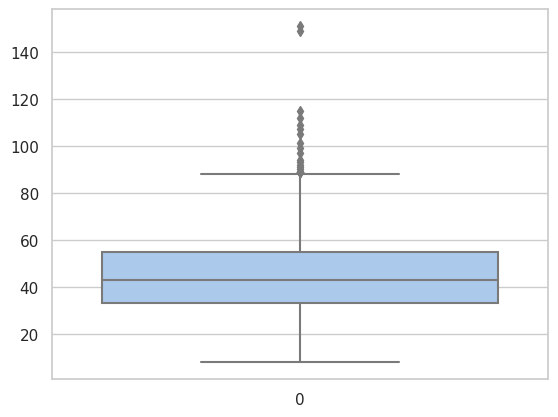

In [33]:
tmp = df.product_name.str.len()
sns.boxplot(tmp)

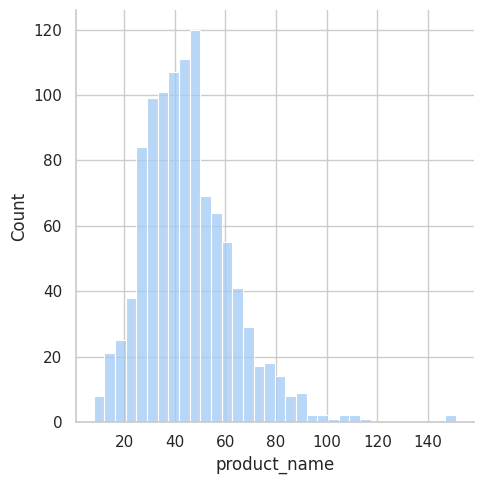

In [34]:
sns.displot(tmp)

## 4.4 Marques

<Axes: >

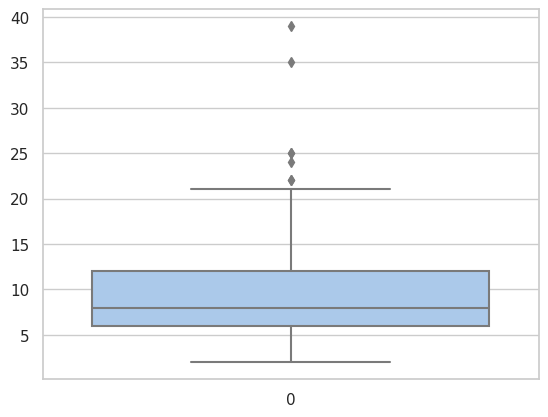

In [35]:
tmp = df.brand.str.len()
sns.boxplot(tmp)

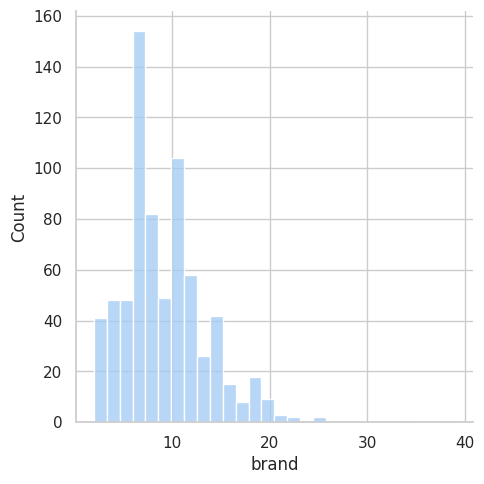

In [36]:
sns.displot(tmp)

## 4.5 Création des documents
Chaque produit donne lieu à la création d'un document unique.

Il s'agira de la fusion des textes des 2 colonnes :
- noms des produits
- descriptions

In [37]:
df['text'] = df['product_name'] + ' ' + df['description']
df = df.drop(columns=['brand', 'product_name', 'description'])
df.head(1)

image    main_category  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg  Home Furnishing   

                                                text  
0  Elegance Polyester Multicolor Abstract Eyelet ...

In [38]:
df.to_csv('/content/drive/MyDrive/Yann Pham-Van - Data Scientist - OpenClassrooms/Projet6-Classifiez automatiquement des biens de consommation/data/cleaned/df_cleaned.csv', index=False)

## 4.6 Exploration du corpus et des documents
### 4.6.1 Affichage de N documents aléatoires

In [39]:
df_samp = df.sample(20)
df_samp

image               main_category  \
714   6acca991d2353781779b866e4f96edd9.jpg             Home Furnishing   
524   797d10fe966b3aa35933669c3425525b.jpg                     Watches   
296   458c697fe5824552890b0e674cf5c109.jpg                   Computers   
1000  4cc971d2c9c0f1056bc124031ed52c1e.jpg            Kitchen & Dining   
935   7b1c5edc85bc7e31edf49ab70034bb3a.jpg    Beauty and Personal Care   
911   7e3d8e737aec8f1eca019302593c732e.jpg  Home Decor & Festive Needs   
100   9613f2f1e65fb1fc7e181e7f83c217da.jpg    Beauty and Personal Care   
152   ec590694e8bf85f75c9200cf418127aa.jpg            Kitchen & Dining   
800   93f45475c82bdee6df73c6e08011b7da.jpg                   Computers   
1030  4d6bf06ef01f80130a1ab28dfdeb7aa3.jpg    Beauty and Personal Care   
626   73901494efea71869576898c68b5eee4.jpg             Home Furnishing   
915   f7514f6068377bcaed80043a5e321131.jpg                   Baby Care   
1017  4748b7ea0e01cffa561f1a7a7a432813.jpg             Home Furnishing   
526   9059227d71995f88a1f48ff63830f716.jpg                     Watches   
811   285075cfac3036e8d51591dfe5ba24ab.jpg             Home Furnishing   
149   fc7abdf67b4d7dbf64dffbab7b37599c.jpg            Kitchen & Dining   
204   6775e3b91baa4d368f6d91eb7c24578b.jpg            Kitchen & Dining   
170   9077acd25761ea067ac6d9369d8fdf16.jpg            Kitchen & Dining   
495   40efb9474b44fba54b5d2a8df121d727.jpg                     Watches   
994   fc8ff72b68b0f3736a9aff8f03aa712f.jpg            Kitchen & Dining   

                                                   text  
714   Home Originals Abstract, Checkered Double Blan...  
524   Noise NOSWW001 Analog Watch  - For Men, Women ...  
296   I Ball IBCTDC 160/2gb/DDR2 with Dual Core 2 RA...  
1000  Lock&Lock Kitchen  - 5.5 L Polypropylene Multi...  
935   Incolor Metalic Lipstick N15 3.8 g Flipkart.co...  
911   painting_art_couple_love__Dance Paper Print Ke...  
100   Goldencollections GC4353 Makeup and Jewellery ...  
152   Prithish Abstract Design 21 Ceramic Mug Buy Pr...  
800   Lapguard SONY VAIO VGN-NW270DB_90 90 Adapter L...  
1030  OMRD RD6697 Hot and cold Pack Specifications o...  
626   Ville Style Polyester Maroon Floral Eyelet Doo...  
915   FS Mini Klub Baby Boy's Woven Casual Shirt Key...  
1017  Aroma Comfort Polyester Cream Self Design Eyel...  
526   Fluid FU203-GR01 Analog-Digital Watch  - For M...  
811   Raymond Abstract Double Blanket Pink Buy Raymo...  
149   Prithish Monster Kids Ceramic Mug Buy Prithish...  
204   Tirupati 4"- Green Wheel Pizza Cutter Buy Tiru...  
170   Prithish Eye Abstract Painting Ceramic Mug Pri...  
495   Sonata 7007YL08 Watch Sonata 7007YL08 Watch - ...  
994   AM Creation Magic  Ceramic Mug Key Features of...

In [40]:
for idx, ser in df_samp.iterrows():
    txt_1 = f"target : {ser['main_category']}\n"
    print(txt_1 + ser['text']+"..."+"\n\n")

target : Home Furnishing
Home Originals Abstract, Checkered Double Blanket Multicolor Buy Home Originals Abstract, Checkered Double Blanket Multicolor at Rs. 1299 at Flipkart.com. Only Genuine Products. Free Shipping. Cash On Delivery!...


target : Watches
Noise NOSWW001 Analog Watch  - For Men, Women Noise NOSWW001 Analog Watch  - For Men, Women - Buy Noise NOSWW001 Analog Watch  - For Men, Women  NOSWW001 Online at Rs.999 in India Only at Flipkart.com. Round Dial, Blue Strap, Water Resistant - Great Discounts, Only Genuine Products, 30 Day Replacement Guarantee, Free Shipping. Cash On Delivery!...


target : Computers
I Ball IBCTDC 160/2gb/DDR2 with Dual Core 2 RAM 160 Hard Disk Specifications of I Ball IBCTDC 160/2gb/DDR2 with Dual Core 2 RAM 160 Hard Disk (Free DOS) Performance Features Processor Speed 2.33 GHz Processor Name Intel Processor Type Dual Core Number of Cores 2 General Brand I Ball Operating System Free DOS Graphics Memory NA GB Model Name IBCTDC 160/2gb/DDR2 Graphics

### 4.6.2 Affichage de documents avec leur catégorie

In [41]:
def print_sample(sub_df, n_samp=10):
    """Affiche n_samp documents d'un corpus"""

    samp = sub_df.sample(n_samp)

    for idx, ser in samp.iterrows():

        txt_1 = f"target : {ser['main_category']}\n"
        print(txt_1+ser['text']+"..."+"\n\n")

In [42]:
list_cat = df['main_category'].unique().tolist()
list_cat

['Home Furnishing',
 'Baby Care',
 'Watches',
 'Home Decor & Festive Needs',
 'Kitchen & Dining',
 'Beauty and Personal Care',
 'Computers']

In [43]:
for cat in list_cat:
    sub_df = df.loc[df['main_category'] == cat]
    print_sample(sub_df, 20)

target : Home Furnishing
JewelKraft Designs Brown, Pink Table Linen Set Specifications of JewelKraft Designs Brown, Pink Table Linen Set General Brand JewelKraft Designs Design Code MN Style Code 411 Color Brown, Pink In the Box Sales Package 6 table mats 6 napkins...


target : Home Furnishing
The Intellect Bazaar Abstract Double Dohar Blue, Brown Buy The Intellect Bazaar Abstract Double Dohar Blue, Brown at Rs. 949 at Flipkart.com. Only Genuine Products. Free Shipping. Cash On Delivery!...


target : Home Furnishing
Cotonex Black, White Cotton Kitchen Linen Set Cotonex Black, White Cotton Kitchen Linen Set (Pack of 2) Price: Rs. 299 Reviews of Cotonex 100% Pure Cotton Glove,Specifications of Cotonex Black, White Cotton Kitchen Linen Set (Pack of 2) General Brand Cotonex Design Code KLS215 Material Cotton Style Code 56213KLS215 Pattern Checkered Design Check Design Color Black, White Dimensions Weight 150 g Additional Features Fabric Care Machine washable, do not dry clean, do not ble

# 5. Pre-processing
## 5.1 Les données

In [44]:
df.head()

image    main_category  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg  Home Furnishing   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg        Baby Care   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg        Baby Care   
3  d4684dcdc759dd9cdf41504698d737d8.jpg  Home Furnishing   
4  6325b6870c54cd47be6ebfbffa620ec7.jpg  Home Furnishing   

                                                text  
0  Elegance Polyester Multicolor Abstract Eyelet ...  
1  Sathiyas Cotton Bath Towel Specifications of S...  
2  Eurospa Cotton Terry Face Towel Set Key Featur...  
3  SANTOSH ROYAL FASHION Cotton Printed King size...  
4  Jaipur Print Cotton Floral King sized Double B...

In [45]:
df.shape

(1050, 3)

## 5.2 Travail sur un document spécifique choisi aléatoirement

In [46]:
doc = df.text.sample(1)
doc = doc.values[0]
doc

"Babeezworld Baby Boy's Romper Key Features of Babeezworld Baby Boy's Romper Fabric: Cotton Brand Color: Blue:Green,Babeezworld Baby Boy's Romper Price: Rs. 499 Babeezworld presents a cute baby dungaree set for your little one.This dungaree set comes with a trendy round neck cotton t-shirt with shoulder loops for ease and comfort fit. Set is made of soft cotton material and has adjustable straps with two button closures. The front has a special character which gives it a stylish look. This dungaree set is an ideal pick for this summer and is available in multiple colors.,Specifications of Babeezworld Baby Boy's Romper Top Details Sleeve Half Sleeve Number of Contents in Sales Package Pack of 2 Fabric Cotton Type Romper Neck Round Neck General Details Pattern Printed Ideal For Baby Boy's Fabric Care Wash with Similar Colors, Use Detergent for Colors"

### 5.2.1 Minuscules

In [47]:
doc = doc.lower()
doc

"babeezworld baby boy's romper key features of babeezworld baby boy's romper fabric: cotton brand color: blue:green,babeezworld baby boy's romper price: rs. 499 babeezworld presents a cute baby dungaree set for your little one.this dungaree set comes with a trendy round neck cotton t-shirt with shoulder loops for ease and comfort fit. set is made of soft cotton material and has adjustable straps with two button closures. the front has a special character which gives it a stylish look. this dungaree set is an ideal pick for this summer and is available in multiple colors.,specifications of babeezworld baby boy's romper top details sleeve half sleeve number of contents in sales package pack of 2 fabric cotton type romper neck round neck general details pattern printed ideal for baby boy's fabric care wash with similar colors, use detergent for colors"

### 5.2.2 Tokenisation

In [48]:
tokens = word_tokenize(doc)
tokens

['babeezworld',
 'baby',
 'boy',
 "'s",
 'romper',
 'key',
 'features',
 'of',
 'babeezworld',
 'baby',
 'boy',
 "'s",
 'romper',
 'fabric',
 ':',
 'cotton',
 'brand',
 'color',
 ':',
 'blue',
 ':',
 'green',
 ',',
 'babeezworld',
 'baby',
 'boy',
 "'s",
 'romper',
 'price',
 ':',
 'rs',
 '.',
 '499',
 'babeezworld',
 'presents',
 'a',
 'cute',
 'baby',
 'dungaree',
 'set',
 'for',
 'your',
 'little',
 'one.this',
 'dungaree',
 'set',
 'comes',
 'with',
 'a',
 'trendy',
 'round',
 'neck',
 'cotton',
 't-shirt',
 'with',
 'shoulder',
 'loops',
 'for',
 'ease',
 'and',
 'comfort',
 'fit',
 '.',
 'set',
 'is',
 'made',
 'of',
 'soft',
 'cotton',
 'material',
 'and',
 'has',
 'adjustable',
 'straps',
 'with',
 'two',
 'button',
 'closures',
 '.',
 'the',
 'front',
 'has',
 'a',
 'special',
 'character',
 'which',
 'gives',
 'it',
 'a',
 'stylish',
 'look',
 '.',
 'this',
 'dungaree',
 'set',
 'is',
 'an',
 'ideal',
 'pick',
 'for',
 'this',
 'summer',
 'and',
 'is',
 'available',
 'in',
 '

Nombre de tokens :

In [49]:
len(tokens)

157

Nombre de tokens uniques :

In [50]:
len(set(tokens))

90

Création d'une fonction d'affichage des informations sur les tokens :

In [51]:
def display_tokens_info(tokens):
    """Informations sur le corpus : nombre total de tokens et nombre de tokens uniques"""

    print(f"nb tokens {len(tokens)}, nb tokens uniques {len(set(tokens))}")
    print(tokens[:30])

Essai de la fonction sur un autre tokenizer :

In [52]:
tokens = wordpunct_tokenize(doc)
display_tokens_info(tokens)

nb tokens 166, nb tokens uniques 93
['babeezworld', 'baby', 'boy', "'", 's', 'romper', 'key', 'features', 'of', 'babeezworld', 'baby', 'boy', "'", 's', 'romper', 'fabric', ':', 'cotton', 'brand', 'color', ':', 'blue', ':', 'green', ',', 'babeezworld', 'baby', 'boy', "'", 's']


### 5.2.3 Stopwords

In [53]:
stop_words = set(stopwords.words('english'))
print(stop_words)

{'in', "hasn't", 'for', 'through', 'nor', 'a', 'than', 'can', 'our', 'how', 'both', 'while', 'are', 'will', "won't", 'themselves', 'whom', 'does', 'but', 'then', 'with', 'him', "you'd", 'out', 'she', "needn't", 'shan', 'having', 'her', 'not', 'or', 'some', 'where', 'only', 'before', 'of', 'herself', 's', 'to', 'its', "weren't", 'over', 'own', 'm', 't', "don't", 'll', 'is', 'down', 'me', 'here', 'isn', 'itself', 'again', 'weren', 'into', 'mightn', 'very', 'wasn', "wouldn't", 'which', 'if', 'doing', 'against', 'you', 'by', 'who', 'do', 'most', "didn't", "you're", 'ain', 'it', 'those', 'too', "that'll", 'theirs', 'no', 'under', 'won', 'mustn', 'yourselves', 'all', "isn't", 'doesn', 'more', 'further', 'being', "couldn't", 'should', 'hadn', 'these', 'about', "wasn't", 'ours', 'on', 'haven', 'what', "hadn't", "haven't", 'them', 'been', 'myself', 'needn', 'ourselves', 'don', 'so', 'his', 'any', "you've", 'why', 'i', 'that', 'until', 'your', 'as', 'have', 'o', 'hasn', 've', 'few', 'ma', 'did',

In [54]:
tokens = [w for w in tokens if w not in stop_words]
display_tokens_info(tokens)

nb tokens 124, nb tokens uniques 77
['babeezworld', 'baby', 'boy', "'", 'romper', 'key', 'features', 'babeezworld', 'baby', 'boy', "'", 'romper', 'fabric', ':', 'cotton', 'brand', 'color', ':', 'blue', ':', 'green', ',', 'babeezworld', 'baby', 'boy', "'", 'romper', 'price', ':', 'rs']


Encore un autre tokenizer :

In [55]:
tokenizer = RegexpTokenizer(r"\w+")
tokens = tokenizer.tokenize(doc)
display_tokens_info(tokens)

nb tokens 148, nb tokens uniques 87
['babeezworld', 'baby', 'boy', 's', 'romper', 'key', 'features', 'of', 'babeezworld', 'baby', 'boy', 's', 'romper', 'fabric', 'cotton', 'brand', 'color', 'blue', 'green', 'babeezworld', 'baby', 'boy', 's', 'romper', 'price', 'rs', '499', 'babeezworld', 'presents', 'a']


Suppression des stopwords :

In [56]:
tokens = [w for w in tokens if w not in stop_words]
display_tokens_info(tokens)

nb tokens 106, nb tokens uniques 71
['babeezworld', 'baby', 'boy', 'romper', 'key', 'features', 'babeezworld', 'baby', 'boy', 'romper', 'fabric', 'cotton', 'brand', 'color', 'blue', 'green', 'babeezworld', 'baby', 'boy', 'romper', 'price', 'rs', '499', 'babeezworld', 'presents', 'cute', 'baby', 'dungaree', 'set', 'little']


C'est ce tokenizer que je garderai par la suite.

In [57]:
def process_text_1(doc, rejoin=False):
    """Fonction de nettoyage de base """

    # lower
    doc = doc.lower().strip()

    # tokenize
    tokenizer = RegexpTokenizer(r"\w+")
    raw_tokens_list = tokenizer.tokenize(doc)

    # stop words

    cleaned_tokens_list = [w for w in raw_tokens_list if w not in stop_words]

    if rejoin:
        return " ".join(cleaned_tokens_list)

    return cleaned_tokens_list

In [58]:
tokens = process_text_1(doc)
display_tokens_info(tokens)

nb tokens 106, nb tokens uniques 71
['babeezworld', 'baby', 'boy', 'romper', 'key', 'features', 'babeezworld', 'baby', 'boy', 'romper', 'fabric', 'cotton', 'brand', 'color', 'blue', 'green', 'babeezworld', 'baby', 'boy', 'romper', 'price', 'rs', '499', 'babeezworld', 'presents', 'cute', 'baby', 'dungaree', 'set', 'little']


## 5.3 Travail sur le corpus entier
### 5.3.1 Construction du corpus brut
Assemblage de tous les documents :

In [59]:
raw_corpus = "".join(df.text.values)
raw_corpus[:1_000]

'Elegance Polyester Multicolor Abstract Eyelet Door Curtain Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant

In [60]:
len(raw_corpus)

545919

Application de la fonction sur tout le corpus :

In [61]:
corpus = process_text_1(raw_corpus)
display_tokens_info(corpus)

nb tokens 68652, nb tokens uniques 6266
['elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'key', 'features', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'curtain', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', '213', 'cm', 'height', 'pack', '2']


Nombre d'apparitions des tokens dans le corpus :

In [62]:
tmp = pd.Series(corpus).value_counts()
tmp

rs          911
cm          641
products    633
free        622
buy         582
           ... 
mornings      1
940           1
masala        1
rava          1
2849          1
Length: 6266, dtype: int64

Affichage des 30 premiers tokens :

In [63]:
tmp.head(30)

rs                911
cm                641
products          633
free              622
buy               582
replacement       568
delivery          567
cash              564
shipping          564
genuine           564
day               543
1                 542
30                503
flipkart          480
watch             479
guarantee         471
com               468
set               441
baby              412
online            396
features          395
mug               394
analog            393
specifications    371
cotton            353
price             352
color             342
pack              329
5                 325
material          312
dtype: int64

Affichage des 30 derniers tokens :

In [64]:
tmp.tail(30)

setsantosh       1
278              1
464              1
perfact          1
12399            1
frill            1
goldbedi         1
washvatika       1
179              1
elixir           1
portibility      1
1295             1
4704             1
qrs              1
inspired         1
duratble         1
mugshopmania     1
fall             1
platform         1
bottlegayatri    1
244              1
artisanslal      1
mugd             1
1349             1
hygienic         1
mornings         1
940              1
masala           1
rava             1
2849             1
dtype: int64

Distribution des tokens :

In [65]:
tmp.describe()

count    6266.000000
mean       10.956272
std        41.341047
min         1.000000
25%         1.000000
50%         2.000000
75%         6.000000
max       911.000000
dtype: float64

Boîte à moustaches :

<Axes: >

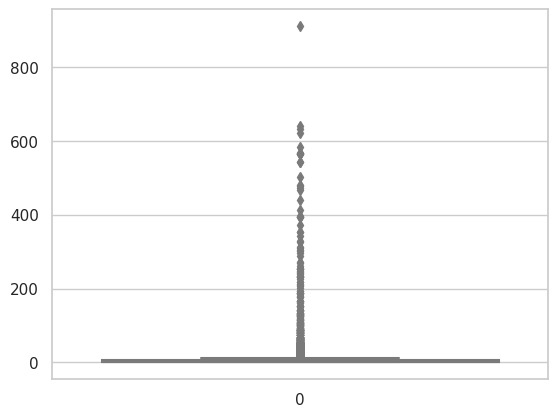

In [66]:
sns.boxplot(tmp)

### 5.3.2 Liste des tokens rares
Inutilité des mots uniques :

In [67]:
tmp = pd.Series(corpus).value_counts()
list_unique_words = tmp[tmp==1]
list_unique_words[:30]

planes           1
aware            1
052              1
lilac            1
softright        1
57               1
avirug85001      1
921              1
dsnsan           1
southampton      1
beds             1
1loomkart        1
nutrient         1
psychic          1
emotional        1
2222             1
abilities        1
1195             1
mb               1
length225        1
979              1
129              1
elegantly        1
ordered          1
selling          1
acts             1
straddles        1
soul             1
recently         1
comprehensive    1
dtype: int64

In [68]:
len(list_unique_words)

1846

In [69]:
list_unique_words = list(list_unique_words.index)
list_unique_words[:30]

['planes',
 'aware',
 '052',
 'lilac',
 'softright',
 '57',
 'avirug85001',
 '921',
 'dsnsan',
 'southampton',
 'beds',
 '1loomkart',
 'nutrient',
 'psychic',
 'emotional',
 '2222',
 'abilities',
 '1195',
 'mb',
 'length225',
 '979',
 '129',
 'elegantly',
 'ordered',
 'selling',
 'acts',
 'straddles',
 'soul',
 'recently',
 'comprehensive']

Enregistrement de la liste des mots uniques :

In [70]:
tmp = pd.DataFrame({"words": list_unique_words})
tmp.to_csv("/content/drive/MyDrive/Yann Pham-Van - Data Scientist - OpenClassrooms/Projet6-Classifiez automatiquement des biens de consommation/data/cleaned/unique_words.csv", index=False)

Idem pour une liste des mots présents moins de 5 fois :

In [71]:
tmp = pd.Series(corpus).value_counts()
list_min_5_words = tmp[tmp <= 5]
list_min_5_words[:30]

park            5
84              5
craftuno        5
1800            5
everlasting     5
perfume         5
forever         5
domestic        5
105key          5
relatives       5
polished        5
app             5
pretty          5
agromech        5
drawing         5
cast            5
plating         5
temperature     5
f               5
earth           5
intel           5
maintenance     5
filled          5
tatvaarts       5
availability    5
301             5
ever            5
colorful        5
cookart         5
flowers         5
dtype: int64

In [72]:
len(list_min_5_words)

4604

Sauvegarde de la liste :

In [73]:
list_min_5_words = list(list_min_5_words.index)
tmp = pd.DataFrame({"words": list_min_5_words})
tmp.to_csv("/content/drive/MyDrive/Yann Pham-Van - Data Scientist - OpenClassrooms/Projet6-Classifiez automatiquement des biens de consommation/data/cleaned/min_5_words.csv", index=False)

Idem pour les mots présents moins de 10 fois :

In [74]:
tmp = pd.Series(corpus).value_counts()
list_min_10_words = tmp[tmp <= 10]
list_min_10_words[:30]

anna          10
21            10
solar         10
sunlast       10
casserole     10
tip           10
pulse         10
wi            10
fi            10
offers        10
nylon         10
andre         10
122           10
sparklings    10
settings      10
butter        10
leading       10
310           10
percent       10
gloss         10
junction      10
exporters     10
plo           10
services      10
5cms          10
device        10
213           10
residue       10
head          10
gum           10
dtype: int64

In [75]:
len(list_min_10_words)

5311

Sauvegarde :

In [76]:
list_min_10_words = list(list_min_10_words.index)
tmp = pd.DataFrame({"words": list_min_10_words})
tmp.to_csv("/content/drive/MyDrive/Yann Pham-Van - Data Scientist - OpenClassrooms/Projet6-Classifiez automatiquement des biens de consommation/data/cleaned/min_10_words.csv", index=False)

### 5.3.3 Seconde fonction de nettoyage

In [77]:
def process_text_2(doc,
                   rejoin=False,
                   list_rare_words=None,
                   min_len_word=3,
                   force_is_alpha=True):
    """cf process_text_1 mais avec list_unique_words, min_len_word, et force_is_alpha

    arguments obligatoires :
    -------------------------
    doc : str : le document (aka un texte au format chaînes de caractères) à traiter

    arguments optionnels :
    -------------------------
    rejoin : bool : si True renvoie une chaîne sinon renvoie la liste des tokens
    list_rare_words : list : une liste des mots rares à exclure
    min_len_word : int : la longueur minimum des mots à ne pas exclure
    force_is_alpha : bool : si True, exclure tous les tokens avec un caractère numérique

    renvoie :
    --------------------------
    une chaîne (si rejoin est True) sinon une liste de tokens
    """

    # list_unique_words
    if not list_rare_words:
        list_rare_words = []

    # lower
    doc = doc.lower().strip()

    # tokenize
    tokenizer = RegexpTokenizer(r"\w+")
    raw_tokens_list = tokenizer.tokenize(doc)

    # classics stopwords
    cleaned_tokens_list = [w for w in raw_tokens_list if w not in stop_words]

    #############################################################
    #############################################################

    # no rare tokens
    non_rare_tokens = [
        w for w in cleaned_tokens_list if w not in list_rare_words]

    # no more len words
    more_than_N = [w for w in non_rare_tokens if len(w) >= min_len_word]

    # only alpha chars
    if force_is_alpha:
        alpha_tokens = [w for w in more_than_N if w.isalpha()]
    else:
        alpha_tokens = more_than_N

    #############################################################
    #############################################################

    # manage return type
    if rejoin:
        return " ".join(alpha_tokens)

    return alpha_tokens

In [78]:
display_tokens_info(corpus)

nb tokens 68652, nb tokens uniques 6266
['elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'key', 'features', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'curtain', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', '213', 'cm', 'height', 'pack', '2']


In [79]:
len(set(corpus))

6266

In [80]:
corpus = process_text_2(raw_corpus,
                        list_rare_words=list_unique_words,
                        rejoin=False)
display_tokens_info(corpus)

nb tokens 57266, nb tokens uniques 3629
['elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'key', 'features', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'curtain', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'height', 'pack', 'price', 'curtain', 'enhances']


In [81]:
len(set(corpus))

3629

### 5.3.4 Stemmatisation et Lemmatisation
J'intègre le choix de choisir l'une ou l'autre méthode dans la fonction de nettoyage.

In [82]:
def process_text_3(doc,
                   rejoin=False,
                   lemm_or_stemm="stem",
                   list_rare_words=None,
                   min_len_word=3,
                   force_is_alpha=True):
    """cf process_text_2 mais avec stemm ou lem

    arguments obligatoires :
    -------------------------
    doc : str : le document (aka un texte au format chaînes de caractères) à traiter

    arguments optionnels :
    -------------------------
    rejoin : bool : si True renvoie une chaîne sinon renvoie la liste des tokens
    lemm_or_stemm : str : si lem effectue une lemmentisation sinon une stemmentisation
    list_rare_words : list : une liste des mots rares à exclure
    min_len_word : int : la longueur minimum des mots à ne pas exclure
    force_is_alpha : bool : si True, exclure tous les tokens avec un caractère numérique

    renvoie :
    --------------------------
    une chaîne (si rejoin est True) sinon une liste de tokens
    """

    # list_unique_words
    if not list_rare_words:
        list_rare_words = []

    # lower
    doc = doc.lower().strip()

    # tokenize
    tokenizer = RegexpTokenizer(r"\w+")
    raw_tokens_list = tokenizer.tokenize(doc)

    # classics stopwords
    cleaned_tokens_list = [w for w in raw_tokens_list if w not in stop_words]

    # no rare tokens
    non_rare_tokens = [
        w for w in cleaned_tokens_list if w not in list_rare_words]

    # no more len words
    more_than_N = [w for w in non_rare_tokens if len(w) >= min_len_word]

    # only alpha chars
    if force_is_alpha:
        alpha_tokens = [w for w in more_than_N if w.isalpha()]
    else:
        alpha_tokens = more_than_N

    #############################################################
    #############################################################

    # stem or lem
    if lemm_or_stemm == "lem":
        trans = WordNetLemmatizer()
        trans_text = [trans.lemmatize(i) for i in alpha_tokens]
    else:
        trans = PorterStemmer()
        trans_text = [trans.stem(i) for i in alpha_tokens]

    #############################################################
    #############################################################

    # manage return type
    if rejoin:
        return " ".join(trans_text)

    return trans_text

Application de la fonction sur le corpus :

In [83]:
corpus = process_text_3(raw_corpus,
                        list_rare_words=list_unique_words,
                        rejoin=False)
pd.Series(corpus).sample(30)

6647        price
48664        inch
12198      perman
24991        sure
45236        cool
43822        lamp
19548    deliveri
54181      specif
28333       brass
39143     premium
19749         com
52473      experi
36790        keya
12947      weight
41344        cash
19284      genuin
20554         day
53774      runway
25011        seri
12649      materi
40966        soft
22571      custom
32366       aapno
30963       light
16714      bhavya
9953      perfect
9126        ensur
14404      barcod
7249       beauti
21291         asu
dtype: object

In [84]:
display_tokens_info(corpus)

nb tokens 57266, nb tokens uniques 2989
['eleg', 'polyest', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'key', 'featur', 'eleg', 'polyest', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'curtain', 'eleg', 'polyest', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'height', 'pack', 'price', 'curtain', 'enhanc']


### Mots anglais seulement

In [85]:
pd.Series(words.words()).sample(30)

113585            melongena
98702            isocyanide
65394          eudiagnostic
31560              catchfly
7062         amphibological
39292        collateralness
65627           Eurasianism
209695                twill
38207          coassistance
128873                  oar
228271             vesicule
22345                 Billy
209910              typeset
115657      microgeological
90277          hypotympanic
8024      Ancistrocladaceae
131045              ooecial
107702              Lobatae
83503                 Helge
141973           Pentstemon
230302              wambais
36637      circumoesophagal
219179              unmagic
220289         unpassionate
10467            antipathic
179684              shandry
41433            conjunctur
166640     remilitarization
138838         paradoxidian
153952           preimpress
dtype: object

In [86]:
len(set(words.words()))

235892

In [87]:
eng_words = [i.lower() for i in words.words()]
eng_words[:30]

['a',
 'a',
 'aa',
 'aal',
 'aalii',
 'aam',
 'aani',
 'aardvark',
 'aardwolf',
 'aaron',
 'aaronic',
 'aaronical',
 'aaronite',
 'aaronitic',
 'aaru',
 'ab',
 'aba',
 'ababdeh',
 'ababua',
 'abac',
 'abaca',
 'abacate',
 'abacay',
 'abacinate',
 'abacination',
 'abaciscus',
 'abacist',
 'aback',
 'abactinal',
 'abactinally']

In [88]:
len(set(eng_words))

234377

In [89]:
ps = PorterStemmer()
eng_words_stem = [ps.stem(i) for i in eng_words]
display_tokens_info(eng_words_stem)

nb tokens 236736, nb tokens uniques 178311
['a', 'a', 'aa', 'aal', 'aalii', 'aam', 'aani', 'aardvark', 'aardwolf', 'aaron', 'aaron', 'aaron', 'aaronit', 'aaronit', 'aaru', 'ab', 'aba', 'ababdeh', 'ababua', 'abac', 'abaca', 'abac', 'abacay', 'abacin', 'abacin', 'abaciscu', 'abacist', 'aback', 'abactin', 'abactin']


In [90]:
lm = WordNetLemmatizer()
eng_words_lem = [lm.lemmatize(i) for i in eng_words]
display_tokens_info(eng_words_lem)

nb tokens 236736, nb tokens uniques 233450
['a', 'a', 'aa', 'aal', 'aalii', 'aam', 'aani', 'aardvark', 'aardwolf', 'aaron', 'aaronic', 'aaronical', 'aaronite', 'aaronitic', 'aaru', 'ab', 'aba', 'ababdeh', 'ababua', 'abac', 'abaca', 'abacate', 'abacay', 'abacinate', 'abacination', 'abaciscus', 'abacist', 'aback', 'abactinal', 'abactinally']


### 5.3.5 4ème fonction de nettoyage

In [91]:
def process_text_4(doc,
                   rejoin=False,
                   lemm_or_stemm="stem",
                   list_rare_words=None,
                   min_len_word=3,
                   force_is_alpha=True,
                   eng_words=None):
    """cf process_text_3 mais avec une sélection de mots anglais uniquement

    arguments obligatoires :
    -------------------------
    doc : str : le document (aka un texte au format chaînes de caractères) à traiter

    arguments optionnels :
    -------------------------
    rejoin : bool : si True renvoie une chaîne sinon renvoie la liste des tokens
    lemm_or_stemm : str : si lem effectue une lemmentisation sinon une stemmentisation
    list_rare_words : list : une liste des mots rares à exclure
    min_len_word : int : la longueur minimum des mots à ne pas exclure
    force_is_alpha : bool : si True, exclure tous les tokens avec un caractère numérique
    eng_words : list : liste de mots anglais

    renvoie :
    --------------------------
    une chaîne (si rejoin est True) sinon une liste de tokens
    """

    # list_unique_words
    if not list_rare_words:
        list_rare_words = []

    # lower
    doc = doc.lower().strip()

    # tokenize
    tokenizer = RegexpTokenizer(r"\w+")
    raw_tokens_list = tokenizer.tokenize(doc)

    # classics stopwords
    cleaned_tokens_list = [w for w in raw_tokens_list if w not in stop_words]

    # no rare tokens
    non_rare_tokens = [
        w for w in cleaned_tokens_list if w not in list_rare_words]

    # no more len words
    more_than_N = [w for w in non_rare_tokens if len(w) >= min_len_word]

    # only alpha chars
    if force_is_alpha:
        alpha_tokens = [w for w in more_than_N if w.isalpha()]
    else:
        alpha_tokens = more_than_N

    # stem or lem
    if lemm_or_stemm == "lem":
        trans = WordNetLemmatizer()
        trans_text = [trans.lemmatize(i) for i in alpha_tokens]
    else:
        trans = PorterStemmer()
        trans_text = [trans.stem(i) for i in alpha_tokens]

    #############################################################
    #############################################################

    # in english
    if eng_words:
        engl_text = [i for i in trans_text if i in eng_words]
    else:
        engl_text = trans_text

    #############################################################
    #############################################################

    # return a list or a string
    if rejoin:
        return " ".join(engl_text)

    return engl_text

In [92]:
corpus = process_text_4(raw_corpus,
                        list_rare_words=list_unique_words,
                        rejoin=False,
                        eng_words=eng_words_stem)
display_tokens_info(corpus)

nb tokens 50920, nb tokens uniques 2283
['eleg', 'polyest', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'key', 'featur', 'eleg', 'polyest', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'curtain', 'eleg', 'polyest', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'height', 'pack', 'price', 'curtain', 'enhanc']


In [93]:
corpus = process_text_4(raw_corpus,
                        list_rare_words=list_min_5_words,
                        rejoin=False,
                        eng_words=eng_words_stem)
display_tokens_info(corpus)

nb tokens 46229, nb tokens uniques 1060
['eleg', 'polyest', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'key', 'featur', 'eleg', 'polyest', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'curtain', 'eleg', 'polyest', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'height', 'pack', 'price', 'curtain', 'enhanc']


In [94]:
corpus = process_text_4(raw_corpus,
                        list_rare_words=list_min_10_words,
                        rejoin=False,
                        eng_words=eng_words_stem)
display_tokens_info(corpus)

nb tokens 42406, nb tokens uniques 672
['eleg', 'polyest', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'key', 'featur', 'eleg', 'polyest', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'curtain', 'eleg', 'polyest', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'height', 'pack', 'price', 'curtain', 'look']


### 5.3.6 Wordcloud

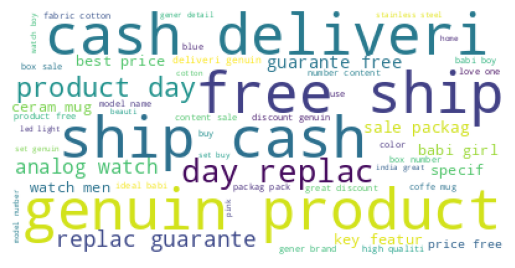

In [95]:
wordcloud = WordCloud(background_color='white',
                      stopwords=[],
                      max_words=50).generate(" ".join(corpus))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## 5.4 Scission du corpus
### 5.4.1 Scissions selon les catégories

In [96]:
df_home_furnishing = df[df.main_category == 'Home Furnishing']
df_baby_care = df[df.main_category == 'Baby Care']
df_watches = df[df.main_category == 'Watches']
df_home_decor_festive_needs = df[df.main_category ==
                                 'Home Decor & Festive Needs']
df_kitchen_dining = df[df.main_category == 'Kitchen & Dining']
df_beauty_personnal_care = df[df.main_category == 'Beauty and Personal Care']
df_computers = df[df.main_category == 'Computers']

In [97]:
list_df = [df_home_furnishing,
           df_baby_care,
           df_watches,
           df_home_decor_festive_needs,
           df_kitchen_dining,
           df_beauty_personnal_care,
           df_computers]

In [98]:
for df_i in list_df:
    display(df_i.sample(1))

image    main_category  \
103  dfbd96036cbc28566e964cff04b5b3a8.jpg  Home Furnishing   

                                                  text  
103  Rama Floral Single Quilts & Comforters Pink-Re...

image main_category  \
622  672d1c3272eae4586eb5994fe408c12a.jpg     Baby Care   

                                                  text  
622  Mee Mee Multifunctional Nursery Diaper Bag Mee...

image main_category  \
550  321f2ab0dd243778c87ac63ace6639f4.jpg       Watches   

                                                  text  
550  Sonata 8098YM01 Analog Watch  - For Women Sona...

image               main_category  \
308  521528ccaa29dd645e869550cae7a249.jpg  Home Decor & Festive Needs   

                                                  text  
308  Ravishing Variety Statue Showpiece  -  17 cm B...

image     main_category  \
218  ce02ab514e4c623dcf7acd7182a7762d.jpg  Kitchen & Dining   

                                                  text  
218  Apex Rolling Pizza Cutter Buy Apex Rolling Piz...

image             main_category  \
414  2d4f1232af970bd19881ceacad6ccfe3.jpg  Beauty and Personal Care   

                                                  text  
414  Playboy London And New York Combo Set Flipkart...

image main_category  \
341  fce2bd96b35d531a4784bc57e19aca4f.jpg     Computers   

                                                  text  
341  Belkin Share Modem (N) Router Buy Belkin Share...

In [99]:
corpus_home_furnishing = " ".join(df_home_furnishing.text)
corpus_baby_care = " ".join(df_baby_care.text)
corpus_watches = " ".join(df_watches.text)
corpus_home_decor_festive_needs = " ".join(df_home_decor_festive_needs.text)
corpus_kitchen_dining = " ".join(df_kitchen_dining.text)
corpus_beauty_personnal_care = " ".join(df_beauty_personnal_care.text)
corpus_computers = " ".join(df_computers.text)

### 5.4.2 Application de la fonction à chacun des corpus de catégorie

In [100]:
corpus_home_furnishing = process_text_4(corpus_home_furnishing,
                                        list_rare_words=list_min_10_words,
                                        rejoin=False,
                                        eng_words=eng_words_stem)

In [101]:
corpus_baby_care = process_text_4(corpus_baby_care,
                                  list_rare_words=list_min_10_words,
                                  rejoin=False,
                                  eng_words=eng_words_stem)

In [102]:
corpus_watches = process_text_4(corpus_watches,
                                list_rare_words=list_min_10_words,
                                rejoin=False,
                                eng_words=eng_words_stem)

In [103]:
corpus_home_decor_festive_needs = process_text_4(corpus_home_decor_festive_needs,
                                                 list_rare_words=list_min_10_words,
                                                 rejoin=False,
                                                 eng_words=eng_words_stem)

In [104]:
corpus_kitchen_dining = process_text_4(corpus_kitchen_dining,
                                       list_rare_words=list_min_10_words,
                                       rejoin=False,
                                       eng_words=eng_words_stem)

In [105]:
corpus_beauty_personnal_care = process_text_4(corpus_beauty_personnal_care,
                                              list_rare_words=list_min_10_words,
                                              rejoin=False,
                                              eng_words=eng_words_stem)

In [106]:
corpus_computers = process_text_4(corpus_computers,
                                  list_rare_words=list_min_10_words,
                                  rejoin=False,
                                  eng_words=eng_words_stem)

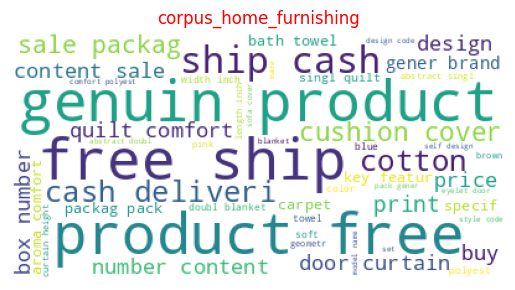

In [107]:
wordcloud = WordCloud(background_color='white',
                      stopwords=[],
                      max_words=50).generate(" ".join(corpus_home_furnishing))
plt.imshow(wordcloud)
plt.axis("off")
plt.title('corpus_home_furnishing', color='red')
plt.show()

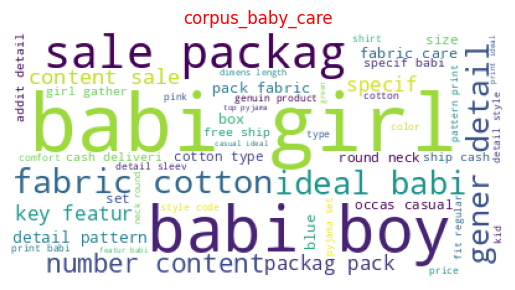

In [108]:
wordcloud = WordCloud(background_color='white',
                      stopwords=[],
                      max_words=50).generate(" ".join(corpus_baby_care))
plt.imshow(wordcloud)
plt.axis("off")
plt.title('corpus_baby_care', color='red')
plt.show()

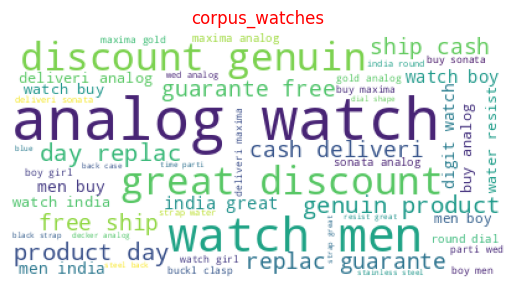

In [109]:
wordcloud = WordCloud(background_color='white',
                      stopwords=[],
                      max_words=50).generate(" ".join(corpus_watches))
plt.imshow(wordcloud)
plt.axis("off")
plt.title('corpus_watches', color='red')
plt.show()

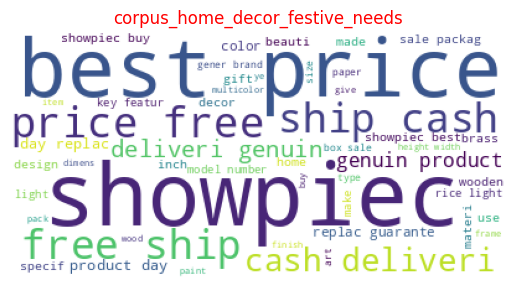

In [110]:
wordcloud = WordCloud(background_color='white',
                      stopwords=[],
                      max_words=50).generate(" ".join(corpus_home_decor_festive_needs))
plt.imshow(wordcloud)
plt.axis("off")
plt.title('corpus_home_decor_festive_needs', color='red')
plt.show()

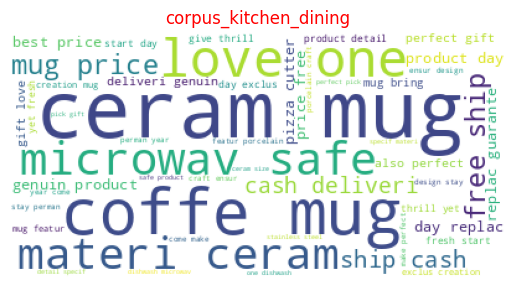

In [111]:
wordcloud = WordCloud(background_color='white',
                      stopwords=[],
                      max_words=50).generate(" ".join(corpus_kitchen_dining))
plt.imshow(wordcloud)
plt.axis("off")
plt.title('corpus_kitchen_dining', color='red')
plt.show()

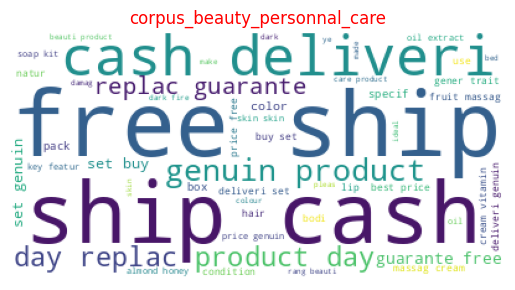

In [112]:
wordcloud = WordCloud(background_color='white',
                      stopwords=[],
                      max_words=50).generate(" ".join(corpus_beauty_personnal_care))
plt.imshow(wordcloud)
plt.axis("off")
plt.title('corpus_beauty_personnal_care', color='red')
plt.show()

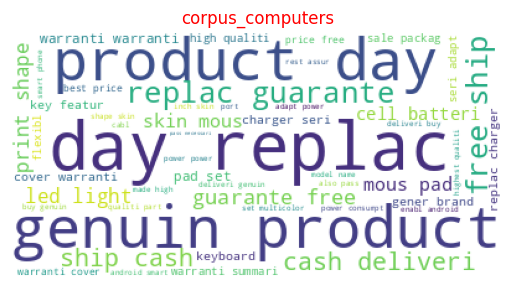

In [113]:
wordcloud = WordCloud(background_color='white',
                      stopwords=[],
                      max_words=50).generate(" ".join(corpus_computers))
plt.imshow(wordcloud)
plt.axis("off")
plt.title('corpus_computers', color='red')
plt.show()

Observation des doublons :

In [114]:
n = 210
doublons = [i for i in pd.Series(corpus_home_furnishing).value_counts().head(n).index
            if (i in pd.Series(corpus_baby_care).value_counts().head(n).index) &
            (i in pd.Series(corpus_watches).value_counts().head(n).index) &
            (i in pd.Series(corpus_home_decor_festive_needs).value_counts().head(n).index) &
            (i in pd.Series(corpus_kitchen_dining).value_counts().head(n).index) &
            (i in pd.Series(corpus_beauty_personnal_care).value_counts().head(n).index) &
            (i in pd.Series(corpus_computers).value_counts().head(n).index)]
doublons

['pack',
 'product',
 'buy',
 'free',
 'deliveri',
 'cash',
 'ship',
 'genuin',
 'color',
 'packag',
 'sale',
 'materi',
 'price',
 'featur',
 'box',
 'brand',
 'specif',
 'gener',
 'dimens',
 'number',
 'type',
 'qualiti',
 'key',
 'made',
 'black',
 'size',
 'weight',
 'use',
 'red',
 'day',
 'ye',
 'make',
 'one',
 'light']

Ces mots, présents dans tous les corpus et à priori non liés spécifiquement à une catégorie, pourront être supprimés.
### 5.4.3 5ème fonction de nettoyage

In [115]:
def process_text_5(doc,
                   rejoin=True,
                   lemm_or_stemm=None,
                   list_rare_words=None,
                   min_len_word=3,
                   eng_words=None,
                   extra_words=None,
                   stop_words=None
                   ):
    """df v4 en excluant une liste de mots non-distinctifs présents dans toutes les catégories
    et en fournissant plus de possibilités pour certains paramètres"""

    # list_stop_words
    if not stop_words:
        stop_words = []

    # list_unique_words
    if not list_rare_words:
        list_rare_words = []

    # extra_words
    if not extra_words:
        extra_words = []

    # lower and strip
    doc = doc.lower().strip()

    # tokenize
    tokenizer = RegexpTokenizer(r"\w+")
    raw_tokens_list = tokenizer.tokenize(doc)

    # remove stop words
    cleaned_tokens_list = [w for w in raw_tokens_list if w not in stop_words]

    # drop rare tokens
    non_rare_tokens_list = [
        w for w in cleaned_tokens_list if w not in list_rare_words]

    # keep only len words > N
    more_than_N = [w for w in non_rare_tokens_list if len(w) >= min_len_word]

    # keep only alpha not num
    alpha_num = [w for w in more_than_N if w.isalpha()]

    # stem or lem
    if lemm_or_stemm == "lem":
        trans = WordNetLemmatizer()
        trans_text = [trans.lemmatize(i) for i in alpha_num]
    elif lemm_or_stemm == "stem":
        trans = PorterStemmer()
        trans_text = [trans.stem(i) for i in alpha_num]
    else:
        trans_text = alpha_num

    # in english
    if eng_words:
        engl_text = [i for i in trans_text if i in eng_words]
    else:
        engl_text = trans_text

    #############################################################
    #############################################################

    # drop extra_words tokens
    final = [w for w in engl_text if w not in extra_words]

    #############################################################
    #############################################################

    # return a list or a string
    if rejoin:
        return " ".join(final)

    return engl_text

## 5.5 Nettoyage final
On utilise des fonctions ultimes, avec des paramètres adaptés aux différentes approches à tester :
- bag of words CountVectorizer
- bag of words Tf-idf
- Word Embeddings avec Word2Vec
- Word Embeddings avec BERT
- Word Embeddings avec USE

### 5.5.1 Fonction de préparation du texte pour le bag of words avec lemmatization (Countvectorizer et Tf_idf)

In [116]:
def transform_bow_lem_fct(doc):
    """Nettoyage final pour bag of words avec lemmatization"""

    new_doc = process_text_5(doc,
                             rejoin=True,
                             lemm_or_stemm='lem',
                             list_rare_words=list_min_10_words,
                             eng_words=eng_words_lem,
                             extra_words=doublons,
                             stop_words=stop_words)

    return new_doc

df["sentence_bow_lem"] = df.text.apply(transform_bow_lem_fct)

### 5.5.2 Fonction de préparation du texte pour le bag of words avec stemmatization (Countvectorizer et Tf_idf, Word2Vec)

In [117]:
def transform_bow_stem_fct(doc):
    """Nettoyage final pour bag of words avec stemmatization"""

    new_doc = process_text_5(doc,
                             rejoin=True,
                             lemm_or_stemm='stem',
                             list_rare_words=list_min_10_words,
                             eng_words=eng_words_stem,
                             extra_words=doublons,
                             stop_words=stop_words)

    return new_doc

df["sentence_bow_stem"] = df.text.apply(transform_bow_stem_fct)

### 5.5.3 Fonction de préparation du texte pour le Deep learning (USE et BERT)

In [118]:
def transform_dl_fct(doc):
    """Nettoyage final pour le Deep learning (USE et BERT)"""

    new_doc = process_text_5(doc,
                             rejoin=True,
                             lemm_or_stemm=None,
                             list_rare_words=None,
                             eng_words=None,
                             extra_words=None,
                             stop_words=None)

    return new_doc


df["sentence_dl"] = df.text.apply(transform_dl_fct)

## 5.6 Dataframe final

In [119]:
df.sample(20)

image               main_category  \
670  d06bb04b096c77dc3302eaf2db336f96.jpg                   Baby Care   
502  71ff6abd7764f2a42fcbefc11429be2d.jpg                     Watches   
939  b7e42b52534c5e49eb03817d754c2153.jpg             Home Furnishing   
30   788dc3a3da91c0f46a7c465e07f91dd4.jpg                     Watches   
276  14826adf9bc4c34ea566dae3d85ef7cf.jpg                     Watches   
809  1d1be744e491ed61e705c20e4a72320d.jpg    Beauty and Personal Care   
439  26269fd0df12630eec4508c2cf3c94e1.jpg             Home Furnishing   
498  11502f02601ff063bf7db0a618354652.jpg                     Watches   
205  c109187e7975ee8fdb2b3dfbdd9dce20.jpg  Home Decor & Festive Needs   
447  8e961e4fd248c9496ca54808d2d2b25f.jpg                   Computers   
283  4d2e9f36823bad0f6fe8c6b19bb92bdb.jpg                     Watches   
339  9a993e1b59649c93f667d38227325066.jpg                   Computers   
449  49f7763dc9c7ece284a1ae27166f8c6c.jpg                   Baby Care   
624  e10cbc680042d27fb747db2ac8e7a585.jpg                   Baby Care   
24   653826cd53f1d9e2c086c0ac7846ef70.jpg                     Watches   
568  f559fdabbcc1f4980f215f847bfdd589.jpg                     Watches   
716  83b7c331ebdd018bea7cecb6171eda96.jpg             Home Furnishing   
698  10b6738d7058738a9a7d107bbb2833f4.jpg             Home Furnishing   
107  b515014adccb1fdf5ff1e2c4a8ff9ea6.jpg             Home Furnishing   
35   81e739c7f3be737152f2e6f520e3494b.jpg             Home Furnishing   

                                                  text  \
670  MH MDF Photo Frame Buy MH MDF Photo Frame for ...   
502  Maxima 01433CMGY Gold Analog Watch  - For Men ...   
939  Welhouse Geometric Double Blanket Grey Buy Wel...   
30   Marvel DW100243 Digital Watch  - For Boys, Gir...   
276  Pittsburgh Polo Club PBPC-505-GRN Analog Watch...   
809  Oxyglow Lacto Bleach & Fruit Massage Cream Wit...   
439  JewelKraft Designs Brown, Pink Table Linen Set...   
498  Times Times_51 Party-Wedding Analog Watch  - F...   
205  Shoppingtara Elephant Pair Gift Showpiece  -  ...   
447  Hako 60W Magsafe Laptop Charger For APPLE MacB...   
283  Yves Bertelin YBSCR557 Analog Watch  - For Wom...   
339  Edimax AR-7286WNA Buy Edimax AR-7286WNA only f...   
449  Saba Garments Baby Girl's Gathered Dress Key F...   
624  Oxolloxo Solid Single Breasted Casual Women's ...   
24   fastrack 38015PL01 Analog Watch  - For Men, Bo...   
568  Flippd FD15102 Analog Watch  - For Men Flippd ...   
716  Home Originals Geometric, Striped Double Blank...   
698  HouseAttire Abstract Cushions Cover Buy HouseA...   
107  Artisan Creation Checkered Single Quilts & Com...   
35   Riva Carpets Cotton Free Bath Mat Classic Loop...   

                                      sentence_bow_lem  \
670  photo frame photo frame photo frame best shipp...   
502  maximum gold watch men maximum gold watch men ...   
939  geometric double blanket grey geometric double...   
30   digital watch boy girl digital watch boy girl ...   
276  polo watch men specification polo watch men ge...   
809  bleach fruit massage cream vitamin bleach frui...   
439  design brown pink table linen set specificatio...   
498  time party wedding watch woman girl time party...   
205  elephant pair gift showpiece elephant pair gif...   
447  hako charger apple adapter feature hako charge...   
283  watch woman specification watch woman general ...   
339    genuine replacement guarantee shipping delivery   
449  baby girl dress feature baby girl dress pink p...   
624  solid single casual woman specification solid ...   
24   watch men boy watch men boy watch men boy indi...   
568  watch men watch men watch men india round dial...   
716  home original geometric striped double blanket...   
698  abstract cushion cover abstract cushion cover ...   
107  creation checkered single quilt comforter brow...   
35   cotton bath classic loop cotton bath classic l...   

                                     sentence_bow_stem  \
670  p

In [120]:
for cat in list_cat:
    sub_df = df[df.main_category == cat]
    for idx, ser in sub_df.sample(10).iterrows():
        print('\nCatégorie = ', cat)
        print('-')
        print(ser['text'])
        print('-')
        print(ser['sentence_bow_stem'])
        print('-')
        print(ser['sentence_bow_lem'])
        print('-')
        print(ser['sentence_dl'])
        print()


Catégorie =  Home Furnishing
-
Elegance Polyester Multicolor Abstract Eyelet Door Curtain Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing

In [121]:
df.isna().mean()

image                0.0
main_category        0.0
text                 0.0
sentence_bow_lem     0.0
sentence_bow_stem    0.0
sentence_dl          0.0
dtype: float64

In [122]:
df.to_csv("/content/drive/MyDrive/Yann Pham-Van - Data Scientist - OpenClassrooms/Projet6-Classifiez automatiquement des biens de consommation/data/cleaned/final_df.csv", index=False)

# 6. Etude de faisabilité de classification textuelle
## 6.1 Préparation commune des traitements

In [123]:
df.head()

image    main_category  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg  Home Furnishing   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg        Baby Care   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg        Baby Care   
3  d4684dcdc759dd9cdf41504698d737d8.jpg  Home Furnishing   
4  6325b6870c54cd47be6ebfbffa620ec7.jpg  Home Furnishing   

                                                text  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1  Sathiyas Cotton Bath Towel Specifications of S...   
2  Eurospa Cotton Terry Face Towel Set Key Featur...   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                                    sentence_bow_lem  \
0  elegance polyester multicolor abstract eyelet ...   
1  cotton bath towel specification cotton bath to...   
2  cotton terry face towel set feature cotton ter...   
3  royal fashion cotton printed king sized double...   
4  print cotton floral king sized double feature ...   

                                   sentence_bow_stem  \
0  eleg polyest multicolor abstract eyelet door c...   
1  cotton bath towel cotton bath towel bath towel...   
2  cotton terri face towel set cotton terri face ...   
3  royal fashion cotton print king doubl royal fa...   
4  print cotton floral king doubl print cotton fl...   

                                         sentence_dl  
0  elegance polyester multicolor abstract eyelet ...  
1  sathiyas cotton bath towel specifications sath...  
2  eurospa cotton terry face towel set key featur...  
3  santosh royal fashion cotton printed king size...  
4  jaipur print cotton floral king sized double b...

In [124]:
l_cat = list(set(df['main_category']))
print("Catégories : ", l_cat)
y_cat_num = [(1-l_cat.index(df.iloc[i]['main_category'])) for i in range(len(df))]

Catégories :  ['Watches', 'Home Decor & Festive Needs', 'Baby Care', 'Home Furnishing', 'Computers', 'Beauty and Personal Care', 'Kitchen & Dining']


In [125]:
df['length_bow_stem'] = df['sentence_bow_stem'].apply(lambda x : len(word_tokenize(x)))
print("max length bow_stem : ", df['length_bow_stem'].max())
df['length_bow_lem'] = df['sentence_bow_lem'].apply(lambda x : len(word_tokenize(x)))
print("max length bow_lem : ", df['length_bow_lem'].max())
df['length_dl'] = df['sentence_dl'].apply(lambda x : len(word_tokenize(x)))
print("max length dl : ", df['length_dl'].max())

max length bow_stem :  165
max length bow_lem :  182
max length dl :  494


## 6.2 Fonctions communes
### 6.2.1 Calcul ARI, T-SNE, clusters

In [126]:
def ARI_fct(features):
    """Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters"""

    time1 = time.time()
    num_labels = len(l_cat)
    tsne = manifold.TSNE(n_components=2, perplexity=27, n_iter=3000,
                         init='random', learning_rate=200, random_state=39)
    X_tsne = tsne.fit_transform(features)

    # Détermination des clusters à partir des données après Tsne
    cls = cluster.KMeans(n_clusters=num_labels, n_init=10, random_state=39)
    cls.fit(X_tsne)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_), 4)
    time2 = np.round(time.time() - time1, 0)
    print("ARI : ", ARI, "time : ", time2)

    return ARI, X_tsne, cls.labels_

### 6.2.2 Visualisation du T-SNE

In [127]:
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI):
    """ Visualisation du Tsne selon les vraies catégories et selon les clusters."""

    fig = plt.figure(figsize=(15, 6))

    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[
              0], labels=l_cat, loc='upper center', bbox_to_anchor=(0.5, 0), title="Categories")
    plt.title('Représentation des produits par catégories réelles')

    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(
        labels), loc='upper center', bbox_to_anchor=(0.5, 0), title="Clusters")
    plt.title('Représentation des produits par clusters')

    plt.show()
    print("ARI : ", ARI)

## 6.3 Approches Bag of Words
### 6.3.1 Préparation sentences
Fonction de création du bag of words (CountVectorizer et Tf-idf)

In [128]:
cvect = CountVectorizer(stop_words='english', max_df=0.95, min_df=1)
ctf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=1)


def bow_cv_ctf(feature):

    cv_fit = cvect.fit(df[feature])
    ctf_fit = ctf.fit(df[feature])

    cv_transform = cvect.transform(df[feature])
    ctf_transform = ctf.transform(df[feature])

    print("CountVectorizer : ", feature)
    print("-----------------")
    ARI, X_tsne, labels = ARI_fct(cv_transform)
    TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)
    print("-"*79)
    print("Tf-idf : ", feature)
    print("--------")
    ARI, X_tsne, labels = ARI_fct(ctf_transform)
    TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

### 6.3.2 Bag of Words - Lemmatisation

CountVectorizer :  sentence_bow_lem
-----------------
ARI :  0.469 time :  25.0


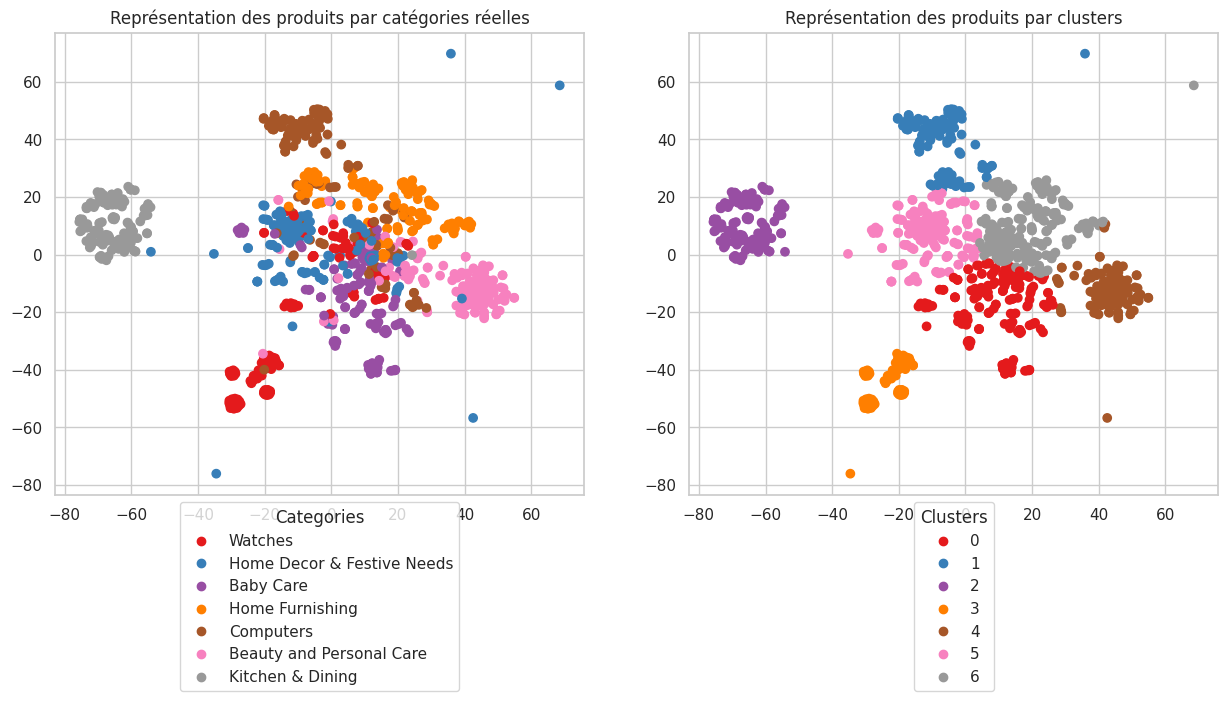

ARI :  0.469
-------------------------------------------------------------------------------
Tf-idf :  sentence_bow_lem
--------
ARI :  0.5003 time :  26.0


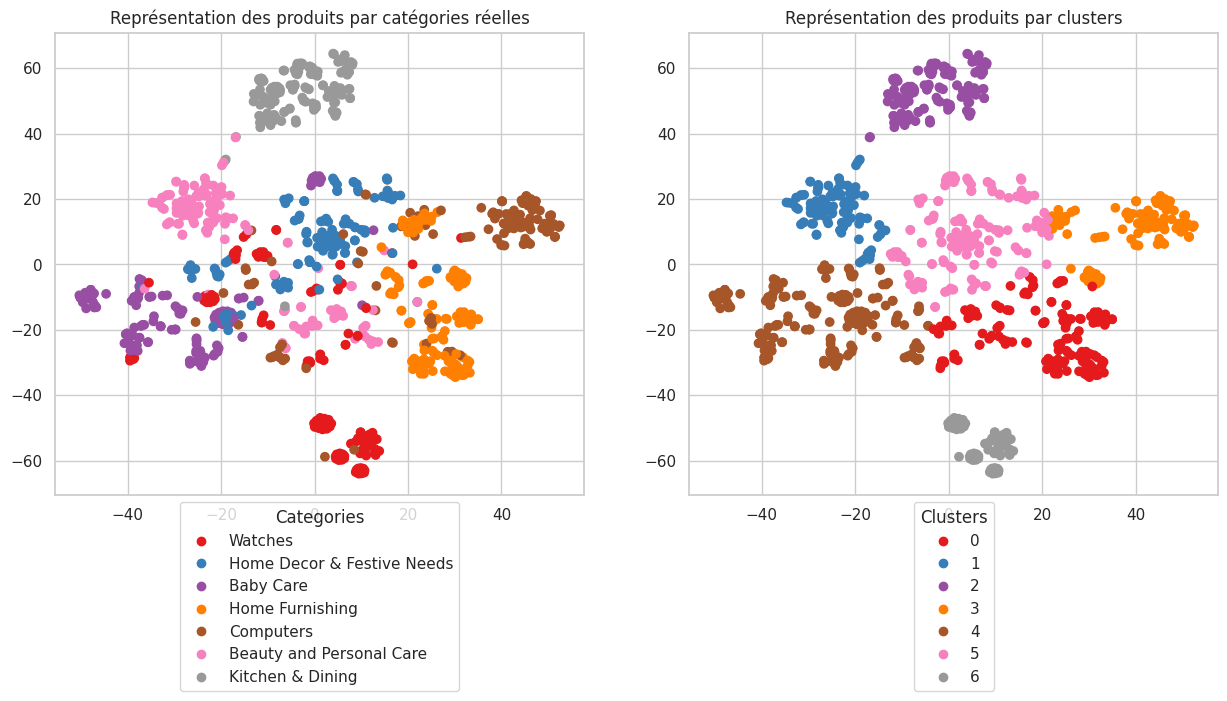

ARI :  0.5003


In [129]:
bow_cv_ctf('sentence_bow_lem')

### 6.3.3 Bag of Words - Stemmatisation

CountVectorizer :  sentence_bow_stem
-----------------
ARI :  0.4926 time :  28.0


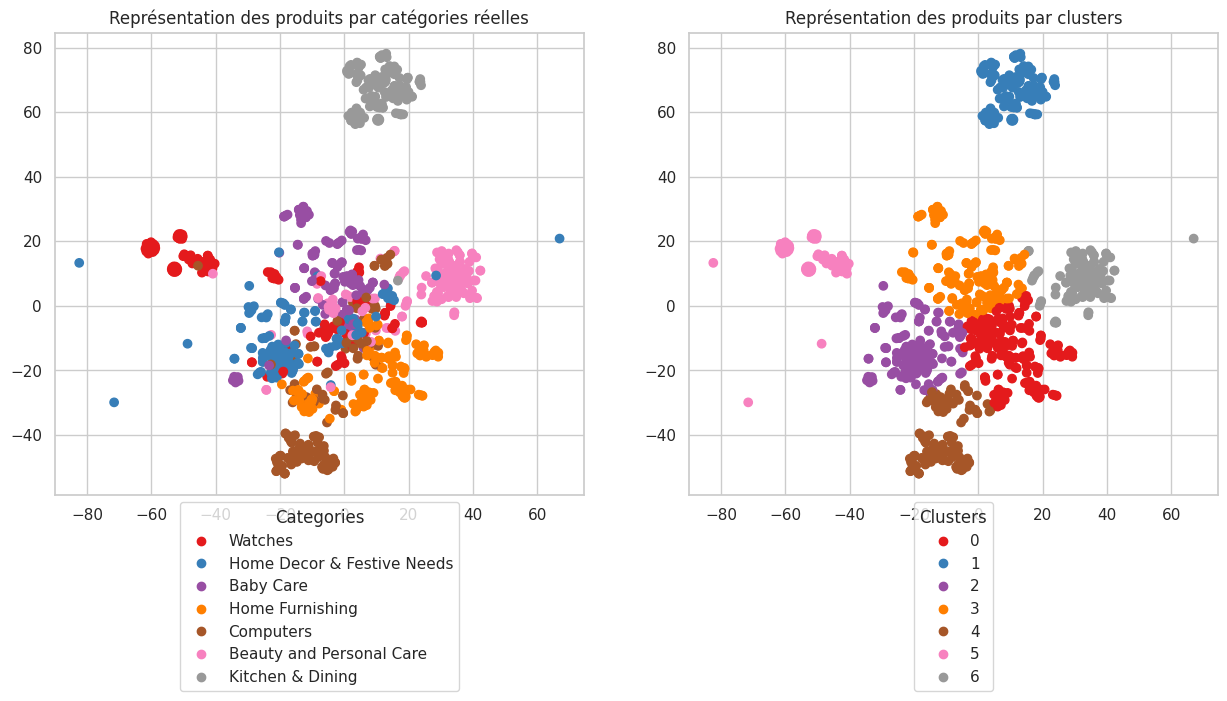

ARI :  0.4926
-------------------------------------------------------------------------------
Tf-idf :  sentence_bow_stem
--------
ARI :  0.5673 time :  27.0


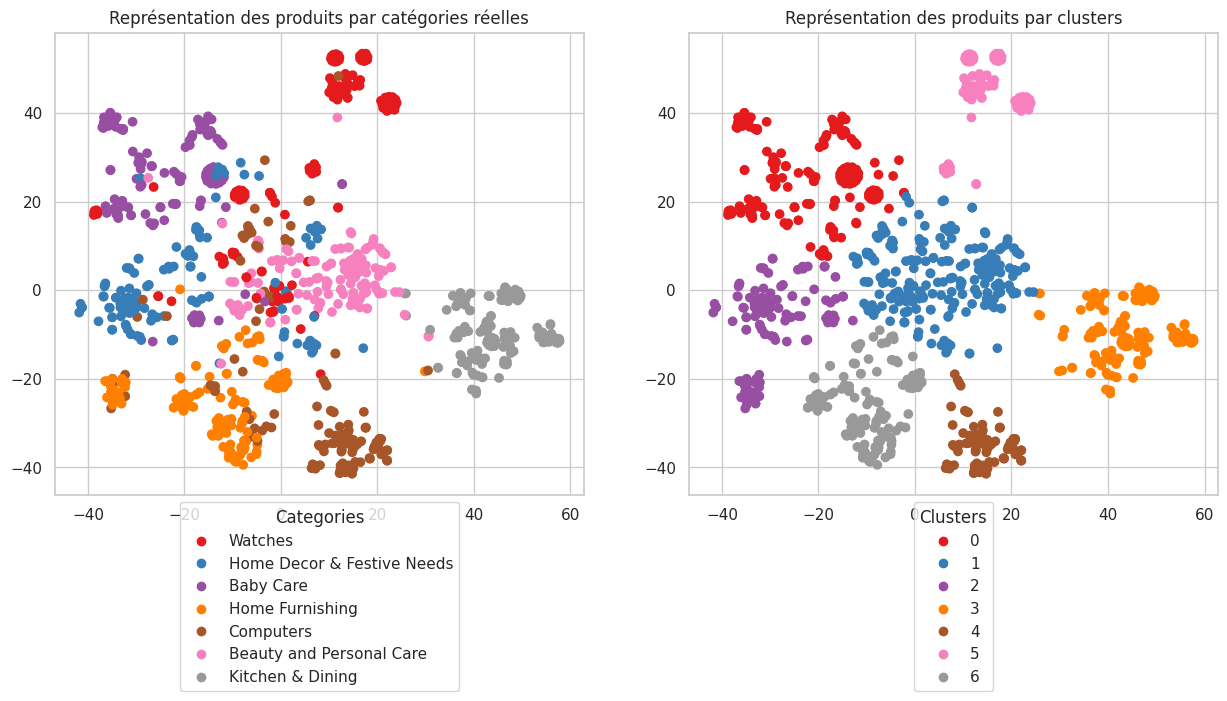

ARI :  0.5673


In [130]:
bow_cv_ctf('sentence_bow_stem')

## 6.4 Approche Word2Vec
### 6.4.1 Création du modèle Word2Vec

In [131]:
w2v_size = 400
w2v_window = 5
w2v_min_count = 1
w2v_epochs = 100
maxlen = 165  # adapt to length of sentences
sentences = df['sentence_bow_stem'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

Création et entraînement du modèle Word2Vec :

In [132]:
print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                   vector_size=w2v_size,
                                   seed=39,
                                   workers=1)
#                                                workers=multiprocessing.cpu_count())
w2v_model.build_vocab(sentences)
w2v_model.train(
    sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 642
Word2Vec trained


Préparation des sentences (tokenization) :

In [133]:
print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                            maxlen=maxlen,
                            padding='post')

num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 643


### 6.4.2 Création de la matrice d'embedding

In [134]:
print("Create Embedding matrix ...")
w2v_size = 400
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i = 0
j = 0

for word, idx in word_index.items():
    i += 1
    if word in w2v_words:
        j += 1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]

word_rate = np.round(j/i, 4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (643, 400)


### 6.4.3 Création du modèle d'embedding

In [135]:
input = Input(shape=(len(x_sentences), maxlen), dtype='float64')
word_input = Input(shape=(maxlen,), dtype='float64')
word_embedding = Embedding(input_dim=vocab_size,
                           output_dim=w2v_size,
                           weights=[embedding_matrix],
                           input_length=maxlen)(word_input)
word_vec = GlobalAveragePooling1D()(word_embedding)
embed_model = Model([word_input], word_vec)

embed_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 165)]             0         
                                                                 
 embedding (Embedding)       (None, 165, 400)          257200    
                                                                 
 global_average_pooling1d (G  (None, 400)              0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 257,200
Trainable params: 257,200
Non-trainable params: 0
_________________________________________________________________


### 6.4.4 Exécution du modèle

In [136]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

33/33 [==============================] - 0s 4ms/step


(1050, 400)

In [137]:
ARI, X_tsne, labels = ARI_fct(embeddings)

ARI :  0.6039 time :  24.0


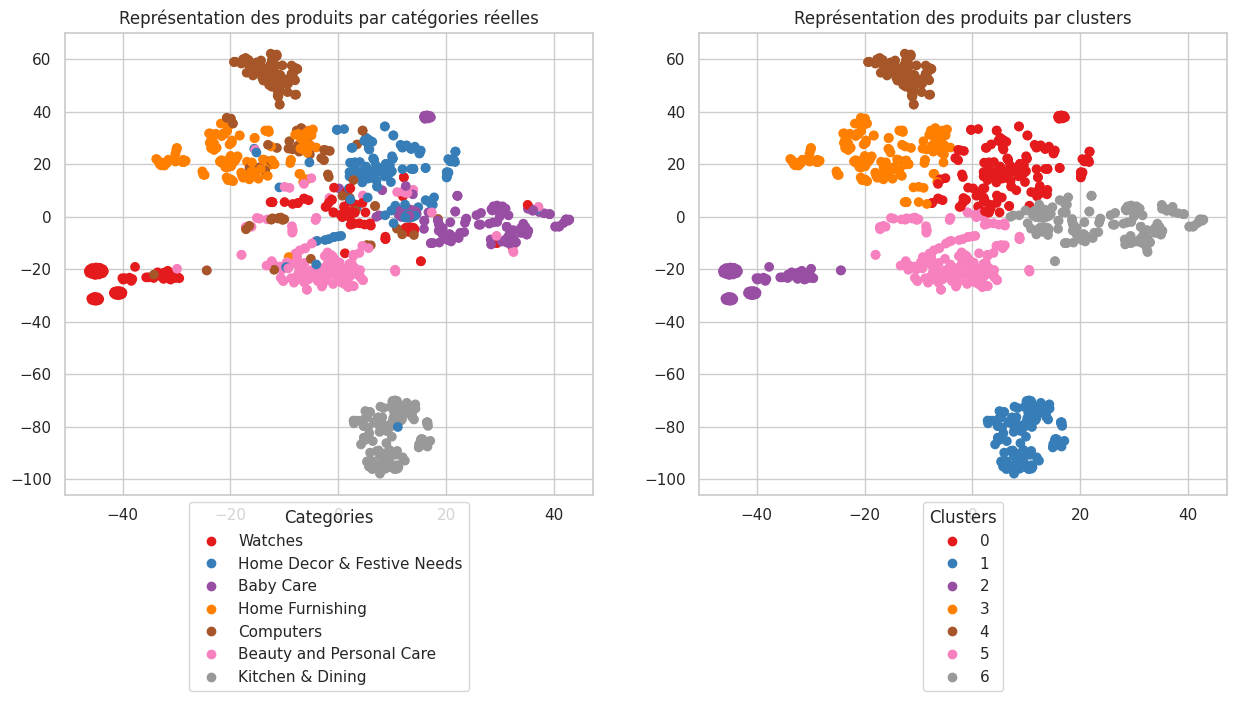

ARI :  0.6039


In [138]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

## 6.5 Approche BERT

In [139]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.12.0
2.12.0
Num GPUs Available:  0
True


### 6.5.1 Fonctions communes

In [140]:
def bert_inp_fct(sentences, bert_tokenizer, max_length):
    """Fonction de préparation des sentences"""
    input_ids = []
    token_type_ids = []
    attention_mask = []
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens=True,
                                              max_length=max_length,
                                              padding='max_length',
                                              return_attention_mask=True,
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")

        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0],
                             bert_inp['token_type_ids'][0],
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)

    return input_ids, token_type_ids, attention_mask, bert_inp_tot


def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF'):
    """Fonction de création des features"""
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size):
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size],
                                                                               bert_tokenizer, max_length)

        if mode == 'HF':    # Bert HuggingFace
            outputs = model.predict(
                [input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode == 'TFhub':  # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids": input_ids,
                                 "input_mask": attention_mask,
                                 "input_type_ids": token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']

        if step == 0:
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else:
            last_hidden_states_tot = np.concatenate(
                (last_hidden_states_tot, last_hidden_states))

    features_bert = np.array(last_hidden_states_tot).mean(axis=1)

    time2 = np.round(time.time() - time1, 0)
    print("temps traitement : ", time2)

    return features_bert, last_hidden_states_tot

### 6.5.2 BERT HuggingFace
**'bert-base-uncased'**

In [141]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
sentences = df['sentence_dl'].to_list()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Création des features :

In [142]:
features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences,
                                                         max_length, batch_size, mode='HF')

1/1 [==============================] - 2s 2s/step
temps traitement :  308.0


In [143]:
ARI, X_tsne, labels = ARI_fct(features_bert)

ARI :  0.3644 time :  26.0


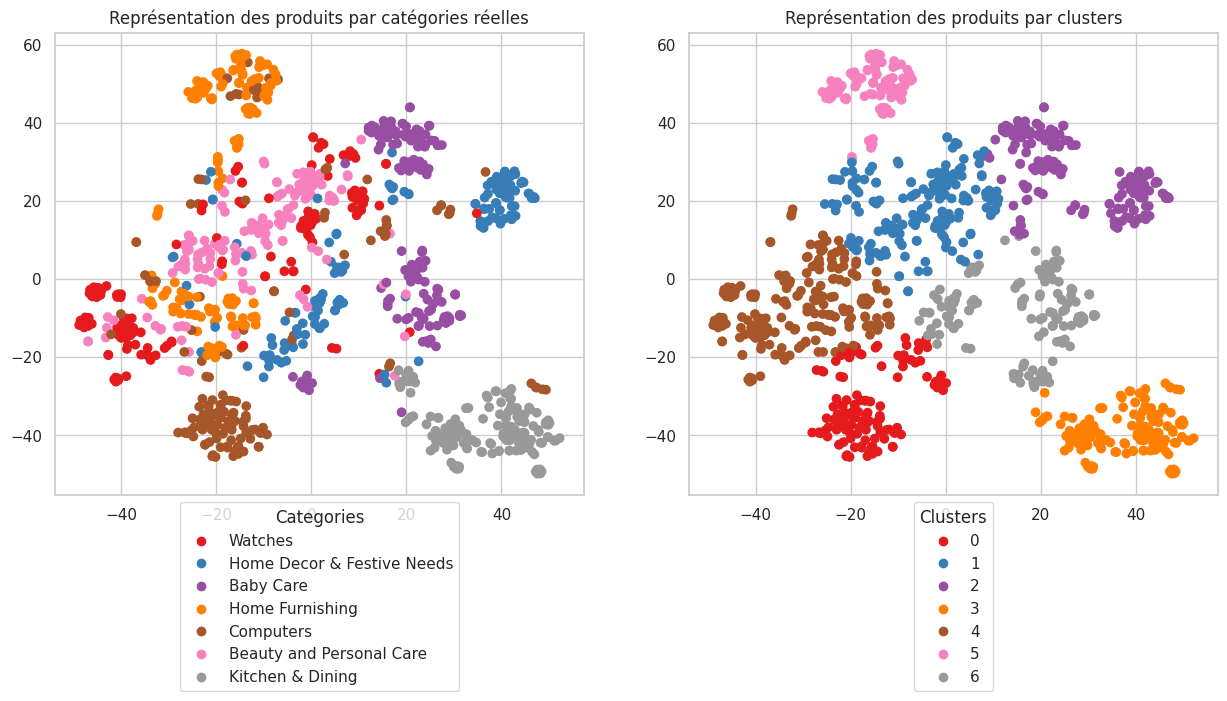

ARI :  0.3644


In [144]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

**'cardiffnlp/twitter-roberta-base-sentiment'**

In [145]:
max_length = 64
batch_size = 10
model_type = 'cardiffnlp/twitter-roberta-base-sentiment'
model = TFAutoModel.from_pretrained(model_type)
sentences = df['sentence_dl'].to_list()

Some layers from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment were not used when initializing TFRobertaModel: ['classifier']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [146]:
features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences,
                                                         max_length, batch_size, mode='HF')

1/1 [==============================] - 2s 2s/step
temps traitement :  302.0


In [147]:
ARI, X_tsne, labels = ARI_fct(features_bert)

ARI :  0.266 time :  24.0


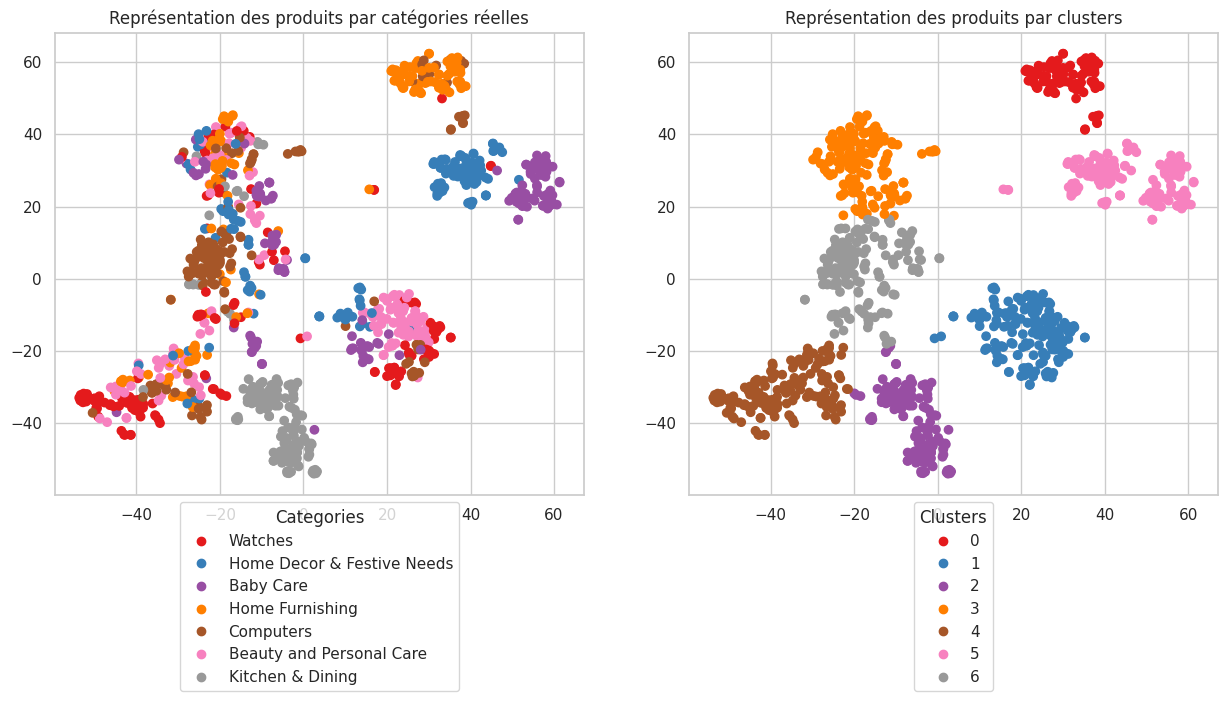

ARI :  0.266


In [148]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

### 6.5.3 BERT hub Tensorflow

In [149]:
model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
bert_layer = hub.KerasLayer(model_url, trainable=True)

In [150]:
sentences = df['sentence_dl'].to_list()

In [151]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = bert_layer

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences,
                                                         max_length, batch_size, mode='TFhub')

temps traitement :  240.0


In [152]:
ARI, X_tsne, labels = ARI_fct(features_bert)

ARI :  0.3724 time :  23.0


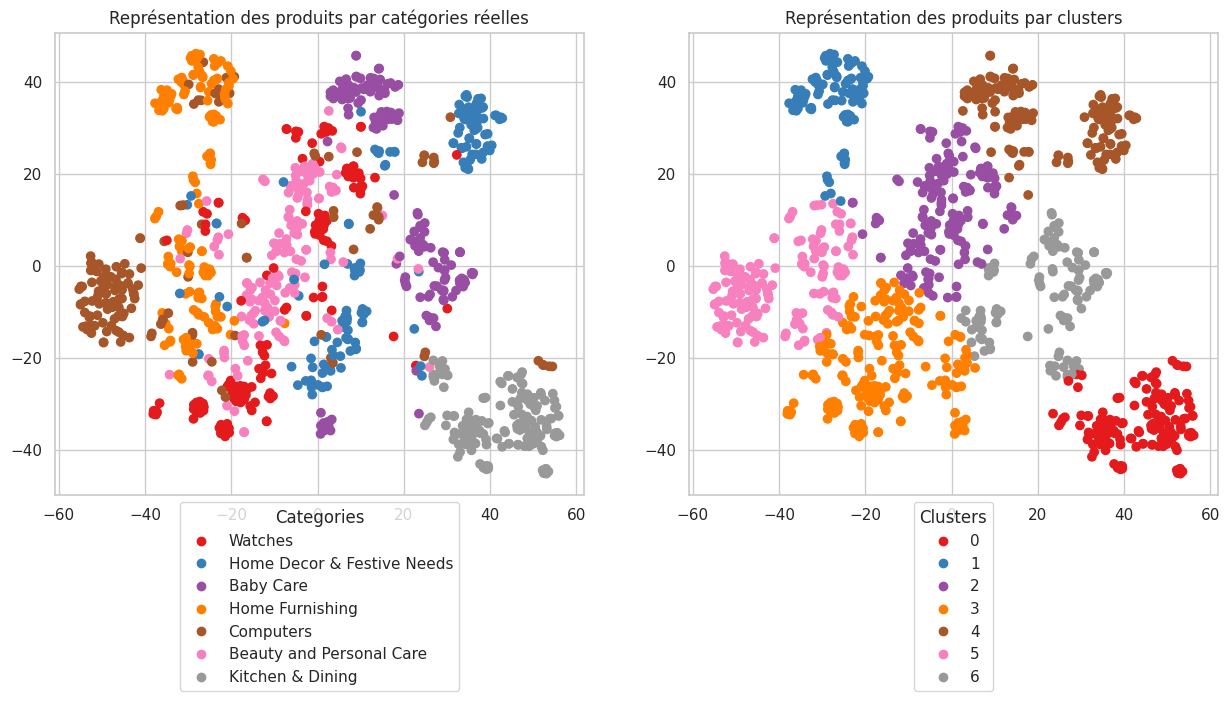

ARI :  0.3724


In [153]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

## 6.6 Approche USE

In [154]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [155]:
def feature_USE_fct(sentences, b_size):
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size):
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step == 0:
            features = feat
        else:
            features = np.concatenate((features, feat))

    time2 = np.round(time.time() - time1, 0)
    return features

In [156]:
batch_size = 10
sentences = df['sentence_dl'].to_list()

In [157]:
features_USE = feature_USE_fct(sentences, batch_size)

In [158]:
ARI, X_tsne, labels = ARI_fct(features_USE)

ARI :  0.3906 time :  26.0


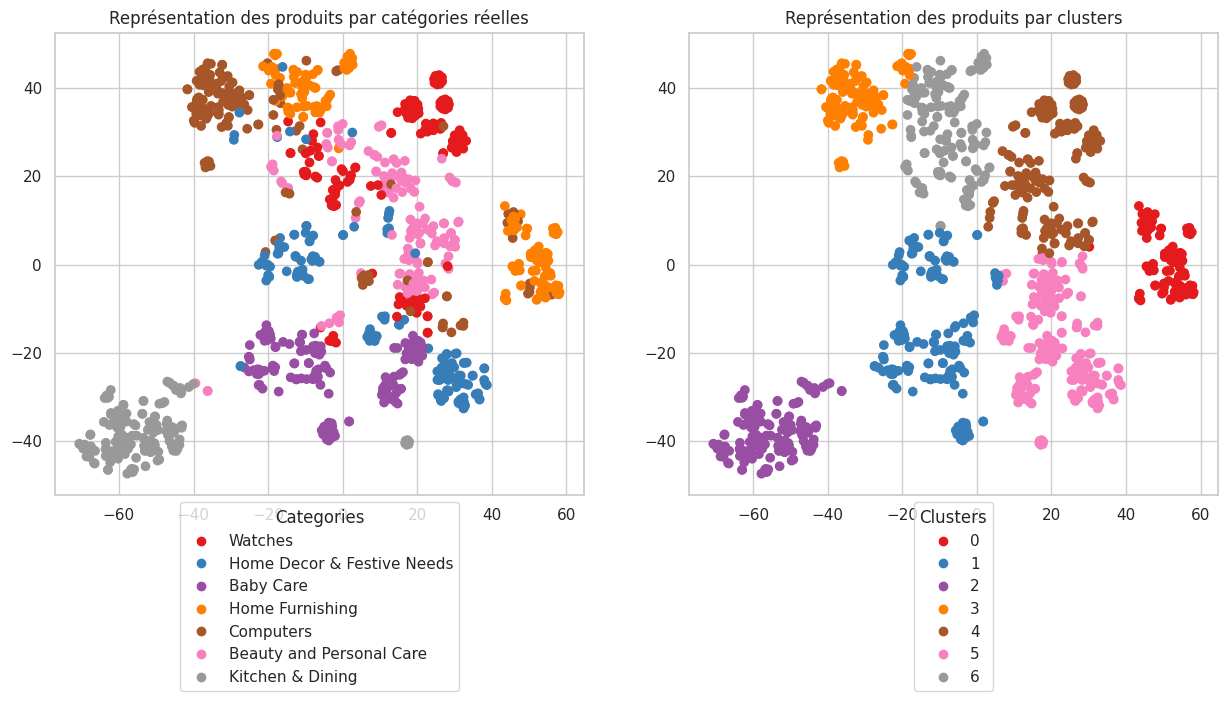

ARI :  0.3906


In [159]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

# 7. Préparation du dataset pour faisabilité de classification image
## 7.1 Import des photos

In [160]:
path = '/content/drive/MyDrive/Yann Pham-Van - Data Scientist - OpenClassrooms/Projet6-Classifiez automatiquement des biens de consommation/data/source/Images/'
list_photos = [file for file in listdir(path)]
print(len(list_photos))

1050


## 7.2 Import du dataset

In [161]:
chemin = "/content/drive/MyDrive/Yann Pham-Van - Data Scientist - OpenClassrooms/Projet6-Classifiez automatiquement des biens de consommation/data/cleaned/"
fn = chemin + 'df_cleaned.csv'
data = pd.read_csv(fn, encoding='utf-8')
data.head(1)

image    main_category  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg  Home Furnishing   

                                                text  
0  Elegance Polyester Multicolor Abstract Eyelet ...

In [162]:
data = data.drop(columns=['text'])
data

image    main_category
0     55b85ea15a1536d46b7190ad6fff8ce7.jpg  Home Furnishing
1     7b72c92c2f6c40268628ec5f14c6d590.jpg        Baby Care
2     64d5d4a258243731dc7bbb1eef49ad74.jpg        Baby Care
3     d4684dcdc759dd9cdf41504698d737d8.jpg  Home Furnishing
4     6325b6870c54cd47be6ebfbffa620ec7.jpg  Home Furnishing
...                                    ...              ...
1045  958f54f4c46b53c8a0a9b8167d9140bc.jpg        Baby Care
1046  fd6cbcc22efb6b761bd564c28928483c.jpg        Baby Care
1047  5912e037d12774bb73a2048f35a00009.jpg        Baby Care
1048  c3edc504d1b4f0ba6224fa53a43a7ad6.jpg        Baby Care
1049  f2f027ad6a6df617c9f125173da71e44.jpg        Baby Care

[1050 rows x 2 columns]

In [163]:
data.groupby("main_category").count()

image
main_category                    
Baby Care                     150
Beauty and Personal Care      150
Computers                     150
Home Decor & Festive Needs    150
Home Furnishing               150
Kitchen & Dining              150
Watches                       150

## 7.3 Affichage d'exemples d'images par catégorie

Home Furnishing
-------


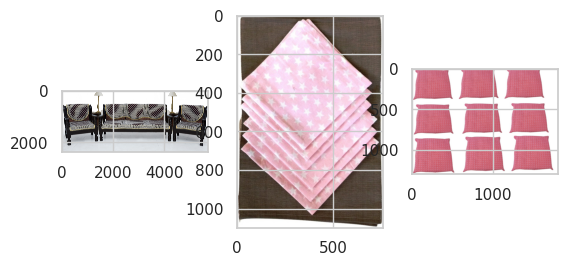

Baby Care
-------


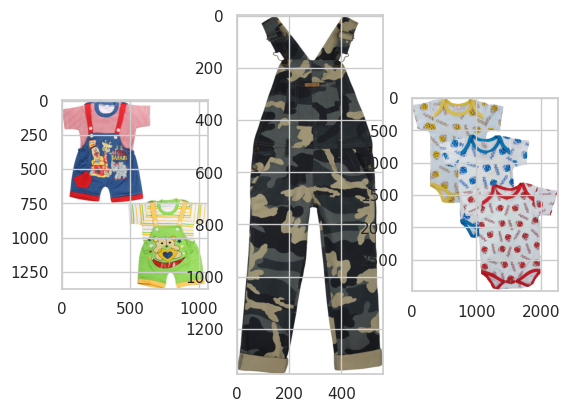

Watches
-------


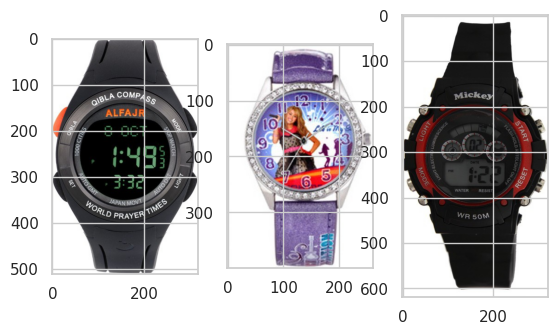

Home Decor & Festive Needs
-------


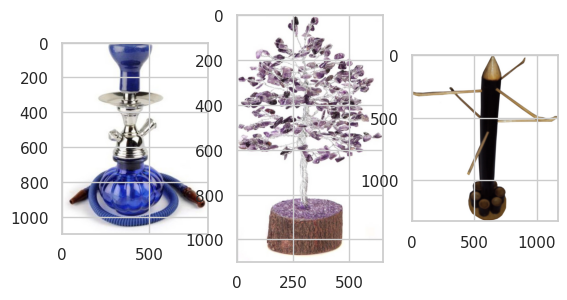

Kitchen & Dining
-------


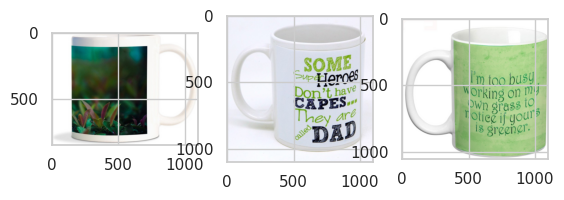

Beauty and Personal Care
-------


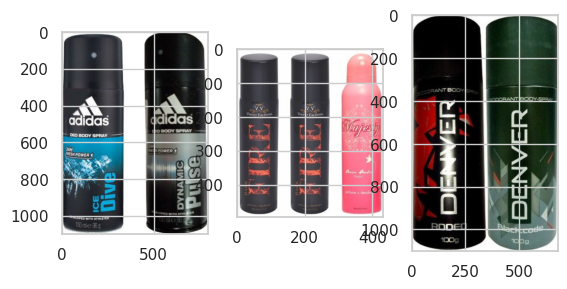

Computers
-------


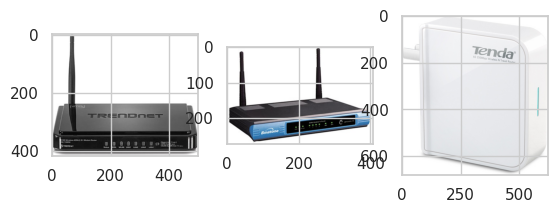

In [164]:
def list_fct(name) :
    list_image_name = [data["image"][i] for i in range(len(data)) if data["main_category"][i]==name]
    return list_image_name

list_baby_care=[data["image"][i] for i in range(len(data)) if data["main_category"][i]=="Baby Care"]
list_beauty_personnal_care=[data["image"][i] for i in range(len(data)) if data["main_category"][i]=="Beauty and Personal Care"]
list_computers=[data["image"][i] for i in range(len(data)) if data["main_category"][i]=="Computers"]
list_home_decor_festive_needs=[data["image"][i] for i in range(len(data)) if data["main_category"][i]=="Home Decor & Festive Needs"]
list_home_furnishing=[data["image"][i] for i in range(len(data)) if data["main_category"][i]=="Home Furnishing"]
list_kitchen_dining=[data["image"][i] for i in range(len(data)) if data["main_category"][i]=="Kitchen & Dining"]
list_watches=[data["image"][i] for i in range(len(data)) if data["main_category"][i]=="Watches"]

for name in list_cat :
    print(name)
    print("-------")
    for i in range(3):
        plt.subplot(130 + 1 + i)
        filename = path + list_fct(name)[i+20]
        image = imread(filename)
        plt.imshow(image)
    plt.show()

# 8. Etude de faisabilité SIFT

## 8.1 Détermination et affichage des descripteurs SIFT

* L'image contient 3098 descripteurs
* Chaque descripteur est un vecteur de longueur 128

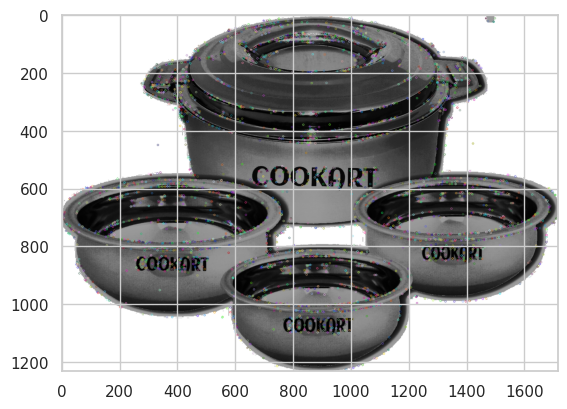

Descripteurs :  (3098, 128)

[[  4.   8.   2. ...   0.   0.   9.]
 [  3.   1.   1. ...   0.   0.   4.]
 [ 19.   2.   1. ...   0.   4.  56.]
 ...
 [ 56. 142.  49. ...   0.   0.   0.]
 [  5.   0.   0. ...   0.   0.   1.]
 [ 25.  10.   0. ...   0.   0.   1.]]


In [165]:
sift = cv2.SIFT_create()
image = cv2.imread(path+list_photos[1],0) # convert in gray
image = cv2.equalizeHist(image)   # equalize image histogram
kp, des = sift.detectAndCompute(image, None)
img=cv2.drawKeypoints(image,kp,image)
plt.imshow(img)
plt.show()
print("Descripteurs : ", des.shape)
print()
print(des)

## 8.2 Pré-traitement des images via SIFT
### 8.2.1 Création des descripteurs de chaque image
* Pour chaque image : passage en gris et égalisation
* création d'une liste de descripteurs par image ("sift_keypoints_by_img") qui sera utilisée pour réaliser les histogrammes par image
* création d'une liste de descripteurs pour l'ensemble des images ("sift_keypoints_all") qui sera utilisée pour créer les clusters de descripteurs

In [166]:
# identification of key points and associated descriptors
sift_keypoints = []
temps1=time.time()
sift = cv2.SIFT_create(500)

for image_num in range(len(list_photos)) :
    if image_num%100 == 0 : print(image_num)
    image = cv2.imread(path+list_photos[image_num],0) # convert in gray
    # image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    res = cv2.equalizeHist(image)   # equalize image histogram
    # resize_image = cv2.resize(res, (224, 224))
    kp, des = sift.detectAndCompute(res, None)
    sift_keypoints.append(des)

sift_keypoints_by_img = np.asarray(sift_keypoints, dtype="object")
sift_keypoints_all    = np.concatenate(sift_keypoints_by_img, axis=0)

print()
print("Nombre de descripteurs : ", sift_keypoints_all.shape)

duration1=time.time()-temps1
print("temps de traitement SIFT descriptor : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000

Nombre de descripteurs :  (517350, 128)
temps de traitement SIFT descriptor :           673.48 secondes


### 8.2.2 Création des clusters de descripteurs
* Utilisation de MiniBatchKMeans pour obtenir des temps de traitement raisonnables

In [167]:
# Determination number of clusters
temps1=time.time()

k = int(round(np.sqrt(len(sift_keypoints_all)),0))
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=39)
kmeans.fit(sift_keypoints_all)

duration1=time.time()-temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

Nombre de clusters estimés :  719
Création de 719 clusters de descripteurs ...


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


temps de traitement kmeans :            14.09 secondes


### 8.2.3 Création des features des images
* Pour chaque image :
   - prédiction des numéros de cluster de chaque descripteur
   - création d'un histogramme = comptage pour chaque numéro de cluster du nombre de descripteurs de l'image

Features d'une image = Histogramme d'une image = Comptage pour une image du nombre de descripteurs par cluster

In [168]:
# Creation of histograms (features)
temps1=time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(sift_keypoints_by_img) :
    if i%100 == 0 : print(i)
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1=time.time()-temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")


0
100
200
300
400
500
600
700
800
900
1000
temps de création histogrammes :             6.62 secondes


## 8.3 Réduction de dimension et analyse
### 8.3.1 Réduction de dimension PCA
* La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%)
* L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE

In [169]:
print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca_sift= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca_sift.shape)

Dimensions dataset avant réduction PCA :  (1050, 719)
Dimensions dataset après réduction PCA :  (1050, 495)


### 8.3.2 Réduction de dimension T-SNE, clusterisation et affichage comparatif "vraies catégories VS clusters"
* Réduction de dimension en 2 composantes T-SNE pour affichage en 2D des images

In [170]:
ARI, X_tsne, cls_labels_ = ARI_fct(feat_pca_sift)

ARI :  0.0027 time :  30.0


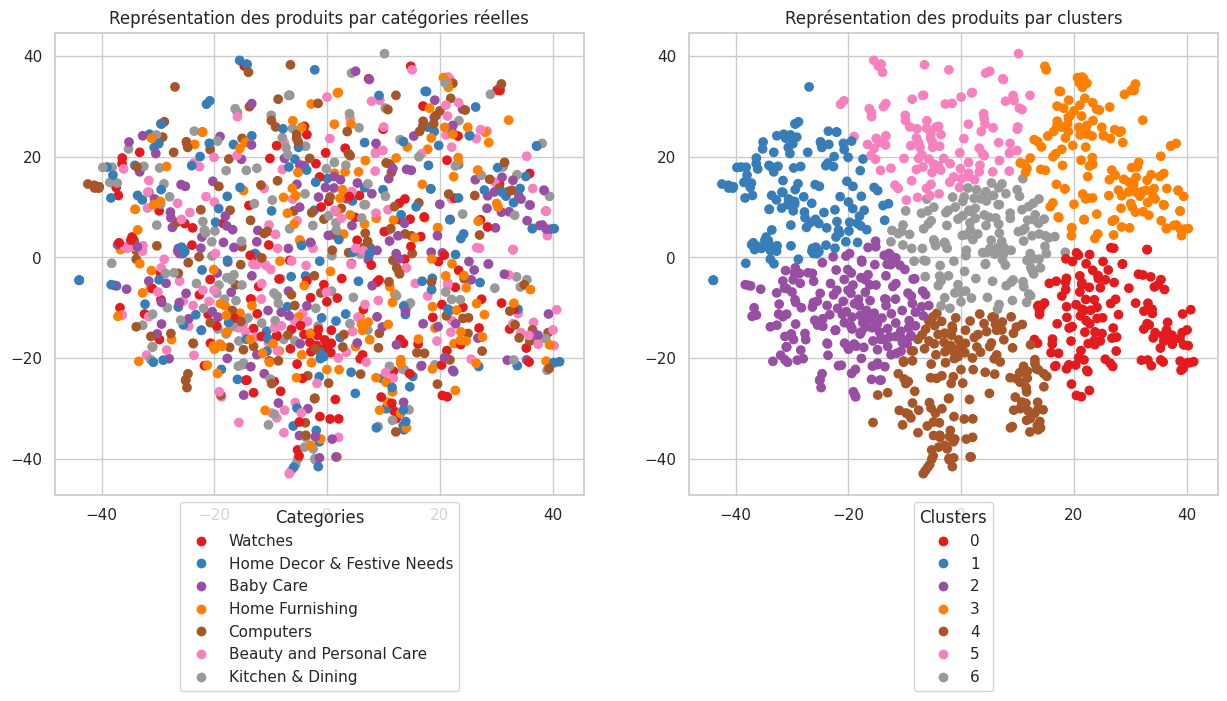

ARI :  0.0027


In [171]:
TSNE_visu_fct(X_tsne, y_cat_num, cls_labels_, ARI)

In [172]:
def conf_mat_transform_2(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)

    # corresp = np.argmax(conf_mat, axis=0)
    corresp = [1,5,2,3,4,6,0]
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x])

    return labels['y_pred_transform']

In [173]:
cls_labels_transform = conf_mat_transform_2(labels, cls_labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

Correspondance des clusters :  [1, 5, 2, 3, 4, 6, 0]
[[ 7 19 15 12 18  8 10]
 [23 29 28 23 25 25 20]
 [16 17 36 16 21 21 20]
 [21 11 18 14 11 16 16]
 [29 27 34 12 36 21 15]
 [27 21 27 49 29 33 20]
 [25 14 30 28 25 16 16]]

              precision    recall  f1-score   support

           0       0.05      0.08      0.06        89
           1       0.21      0.17      0.19       173
           2       0.19      0.24      0.21       147
           3       0.09      0.13      0.11       107
           4       0.22      0.21      0.21       174
           5       0.24      0.16      0.19       206
           6       0.14      0.10      0.12       154

    accuracy                           0.16      1050
   macro avg       0.16      0.16      0.16      1050
weighted avg       0.18      0.16      0.17      1050



<Axes: >

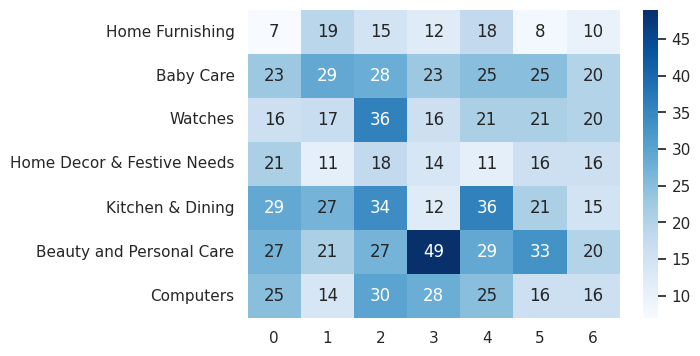

In [174]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_cat],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='0g')

# 9. Etude de faisabilité CNN
## 9.1 Création du modèle pré-entraîné

In [175]:
base_model = VGG16()
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

print(model.summary())

553467096/553467096 [==============================] - 3s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                          

## 9.2 Création des features des images

In [176]:
images_features = []
i=0
for image_file in data["image"] :
    if i%100 == 0 : print(i)
    i +=1
    image = load_img(path+image_file, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    images_features.append(model.predict(image, verbose=0)[0]) # predict from pretrained model

images_features = np.asarray(images_features)
images_features.shape

0
100
200
300
400
500
600
700
800
900
1000


(1050, 4096)

## 9.3 Réduction dimension et analyse
### 9.3.1 Réduction de dimension PCA

In [177]:
print(images_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca_cnn= pca.fit_transform(images_features)
print(feat_pca_cnn.shape)

(1050, 4096)
(1050, 803)


### 9.3.2 Réduction de dimension T-SNE, clusterisation et affichage comparatif "vraies catégories VS clusters"

* L'analyse graphique montre visuellement qu'il est réalisable de séparer automatiquement les images selon leurs vraies classes
* Ceci suffit à démontrer la faisabilité de réaliser ultérieurement une classification supervisée pour déterminer automatiquement les classes des images

In [178]:
ARI, X_tsne, cls_labels_ = ARI_fct(feat_pca_cnn)

ARI :  0.4834 time :  26.0


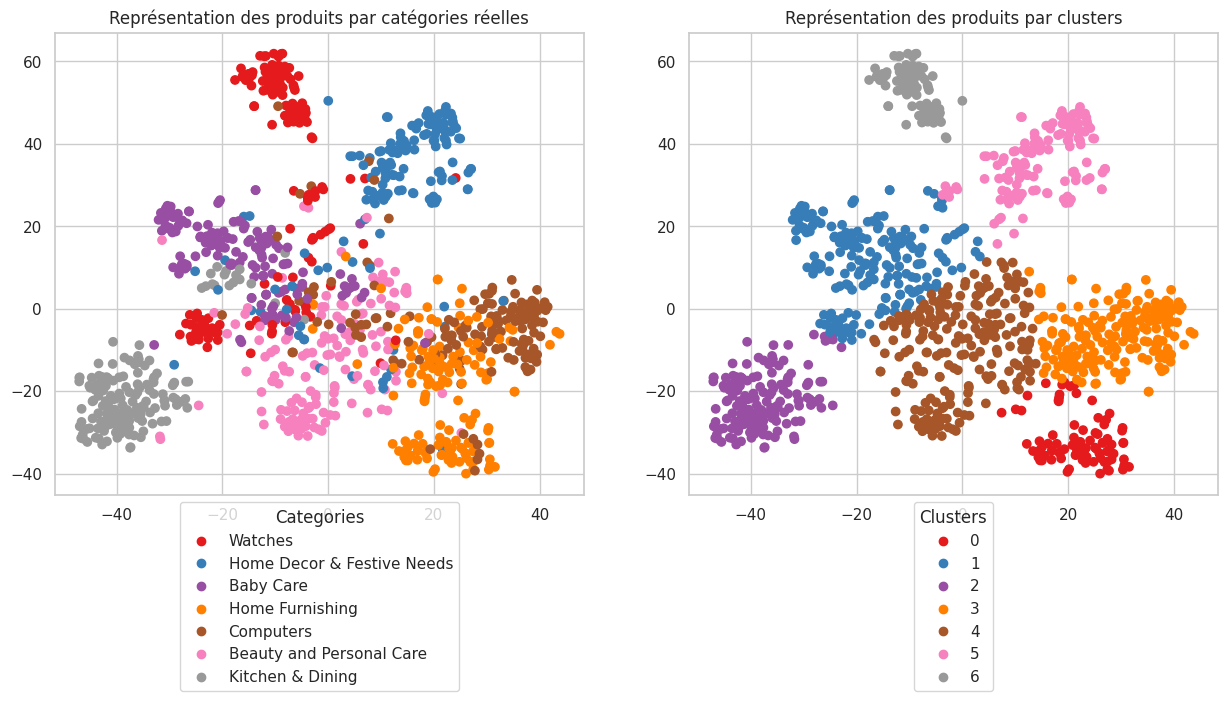

ARI :  0.4834


In [179]:
TSNE_visu_fct(X_tsne, y_cat_num, cls_labels_, ARI)

### 9.3.3 Recherche d'image d'un véritable produit **Computers** mais clusterisé en tant que **Baby Care** :

In [180]:
df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["cluster"] = cls_labels_
list_error_computers = [i for i in range(len(data["image"])) \
                if ((data.iloc[i]['main_category']=='Computers') and (df_tsne.iloc[i]['cluster']==1))]
list_error_computers[0]

47

Affichage de l'image :

tsne1     -13.051225
tsne2      14.219577
cluster     1.000000
Name: 47, dtype: float64


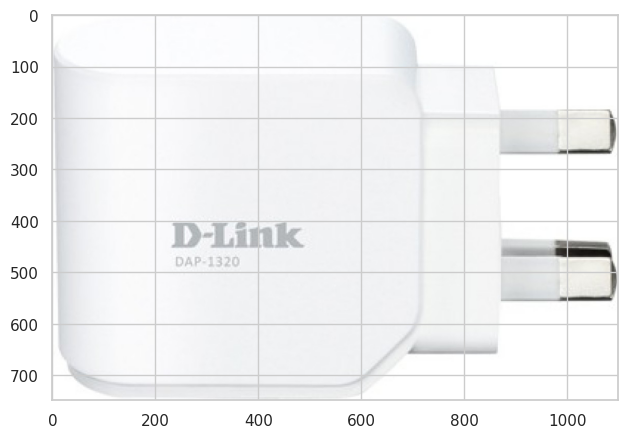

In [181]:
print(df_tsne.iloc[list_error_computers[0]])
fig = plt.figure(figsize=(8,5))
filename = path + data['image'][list_error_computers[0]]
image = imread(filename)
plt.imshow(image)
plt.show()

### 9.3.4 Analyse par classes

In [182]:
le = preprocessing.LabelEncoder()
le.fit(data["main_category"])
data["label"] = le.transform(data["main_category"])
labels = data['label']
conf_mat = metrics.confusion_matrix(labels, cls_labels_)
print(conf_mat)

[[  7   3   0 109  26   4   1]
 [  1  13   1   3  14 117   1]
 [  0 120   1   1  27   1   0]
 [  5  10   3   6 125   1   0]
 [ 75   1   0  67   7   0   0]
 [  0  37   7   0  18  10  78]
 [  0  16 133   0   1   0   0]]


In [183]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)

    corresp = np.argmax(conf_mat, axis=0)
    #corresp = [4,1,6,2,5,0,3]
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x])

    return labels['y_pred_transform']

In [184]:
cls_labels_transform = conf_mat_transform(labels, cls_labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

Correspondance des clusters :  [4 2 6 0 3 1 5]
[[109   4   3  26   7   1   0]
 [  3 117  13  14   1   1   1]
 [  1   1 120  27   0   0   1]
 [  6   1  10 125   5   0   3]
 [ 67   0   1   7  75   0   0]
 [  0  10  37  18   0  78   7]
 [  0   0  16   1   0   0 133]]

              precision    recall  f1-score   support

           0       0.59      0.73      0.65       150
           1       0.88      0.78      0.83       150
           2       0.60      0.80      0.69       150
           3       0.57      0.83      0.68       150
           4       0.85      0.50      0.63       150
           5       0.97      0.52      0.68       150
           6       0.92      0.89      0.90       150

    accuracy                           0.72      1050
   macro avg       0.77      0.72      0.72      1050
weighted avg       0.77      0.72      0.72      1050



<Axes: >

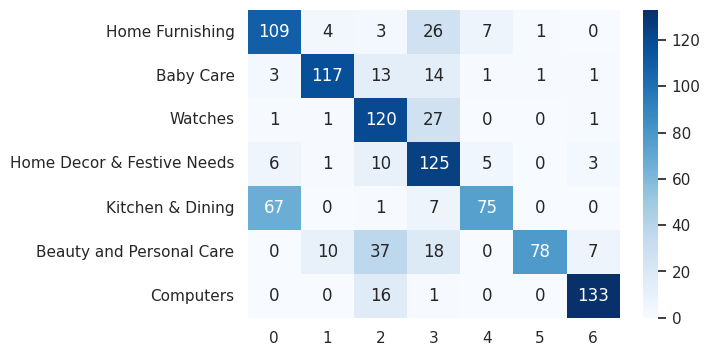

In [185]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_cat],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='0g')

**La catégorie la mieux prédite est "Computers".
La moins bonne prédiction est pour la catégorie "Kitchen & Dining".**